In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


#### opening dataset file and visualizing video

In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

In [11]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

### comparing predictions

In [17]:

if not torch.cuda.is_available():
    print('CUDA is NOT available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# %%
tr = config['video_train']

CUDA is NOT available.  Training on CPU ...


In [18]:

signal_shape, pressure_shape = (1, 4, 64), (64, 64)
print('input chain shape: ', signal_shape, '\noutput chain shape: ',
      pressure_shape)

model_name = tr['model_name']
from video_pipeline import models_src

model_class = eval(f"models_src.{model_name}")

args = []
if model_name.startswith("Param"):
    layers = tr['layers']
    args.append(layers)
args.append(frames_number)
args.append(frames_interval)
model = model_class(pressure_shape[-2:], signal_shape[-2:], *args)
model = model.to(device)

print(model)

input chain shape:  (1, 4, 64) 
output chain shape:  (64, 64)
ParamUnet(
  (step1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
  (finalConv): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  )
  (bottom): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
    (1): Sequential(
   

In [19]:
# loading data
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

In [20]:
checkpoint = torch.load("data/365_id_model.pt",
                     map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval();

#### Закончил играться. Теперь делаю нормальную функцию.

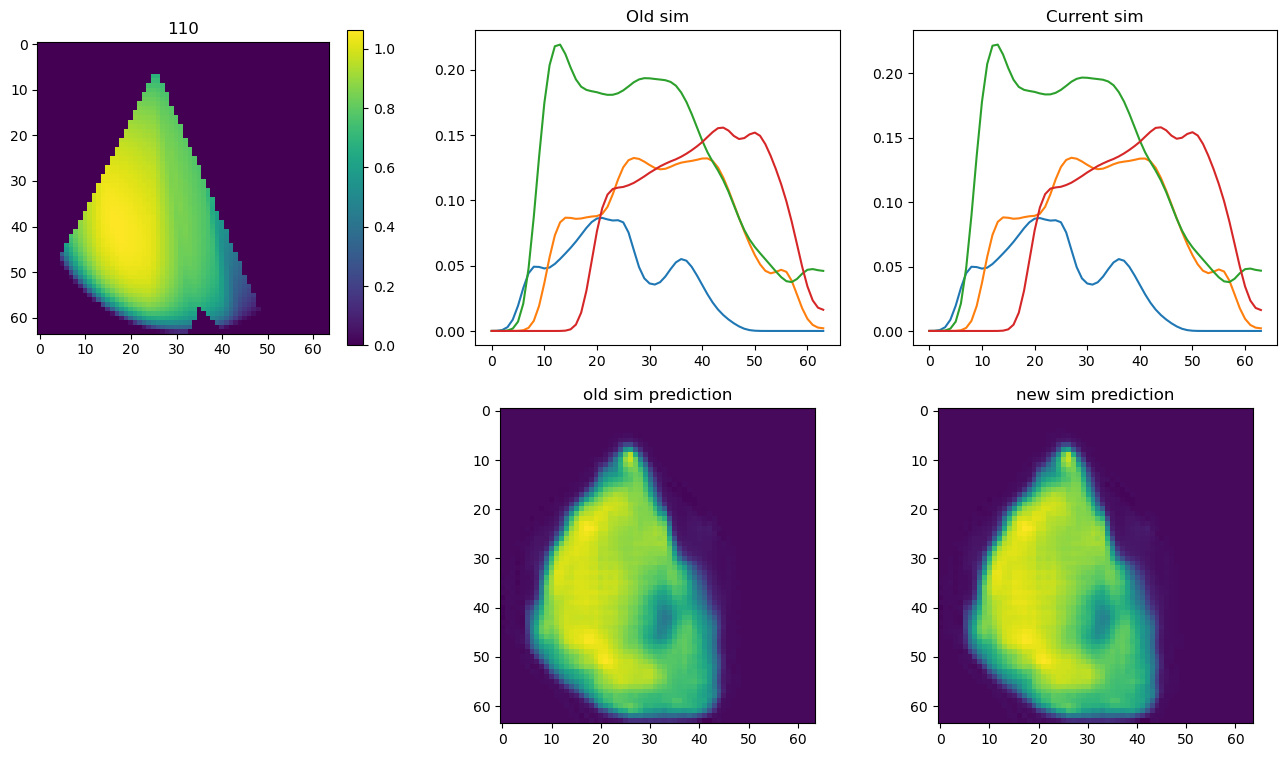

In [21]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

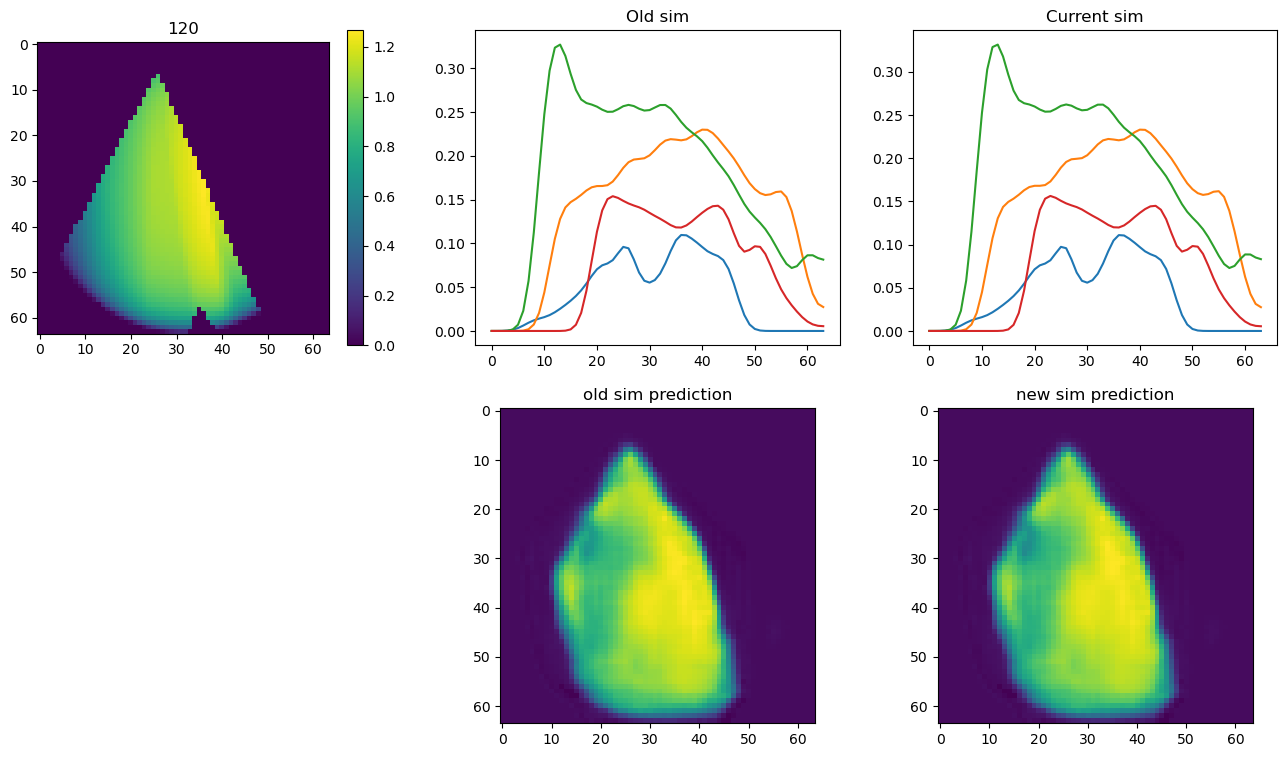

In [22]:

for i in range(60, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

### Выбираю предметы для визуализации

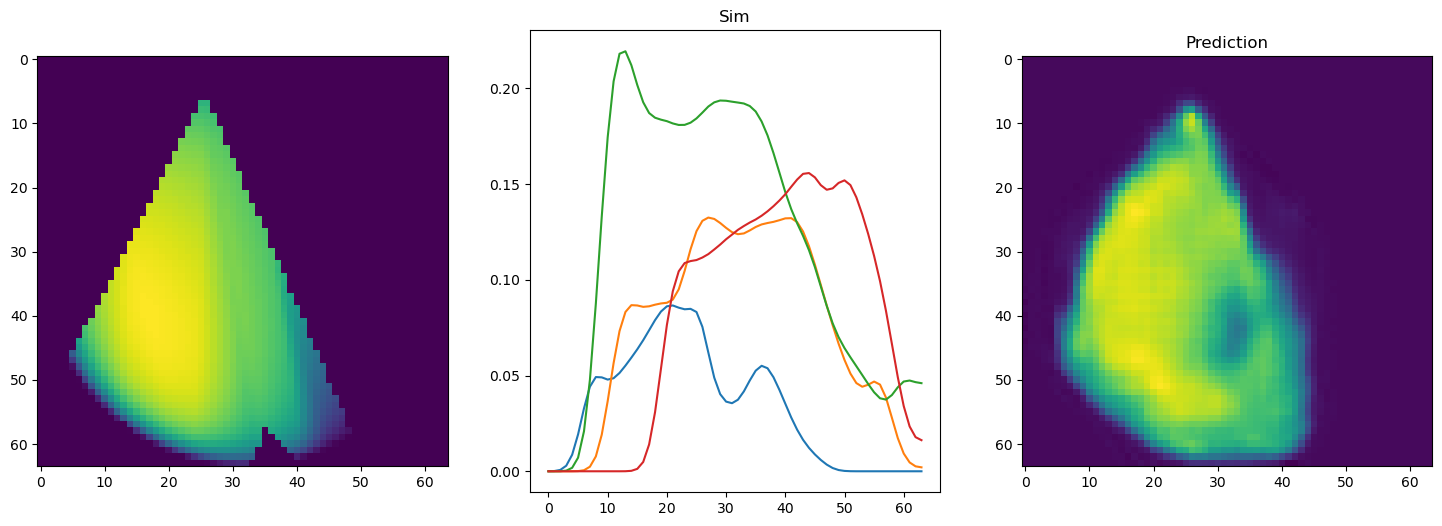

In [25]:
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)


for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(pressure[i])
    # plt.title(f"{i}")
    # plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Sim")
    
    # plt.subplot(2, 3, 3)
    # new_signal = sim.fiber_real_sim(pressure[i])
    # plt.plot(new_signal[0].T)
    # plt.title("Current sim")
    
    plt.subplot(1, 3, 3)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("Prediction")
    
    # plt.subplot(2, 3, 6)
    # map = predict(model, new_signal, device)
    # plt.imshow(map[0])
    # plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

Key_id =  550


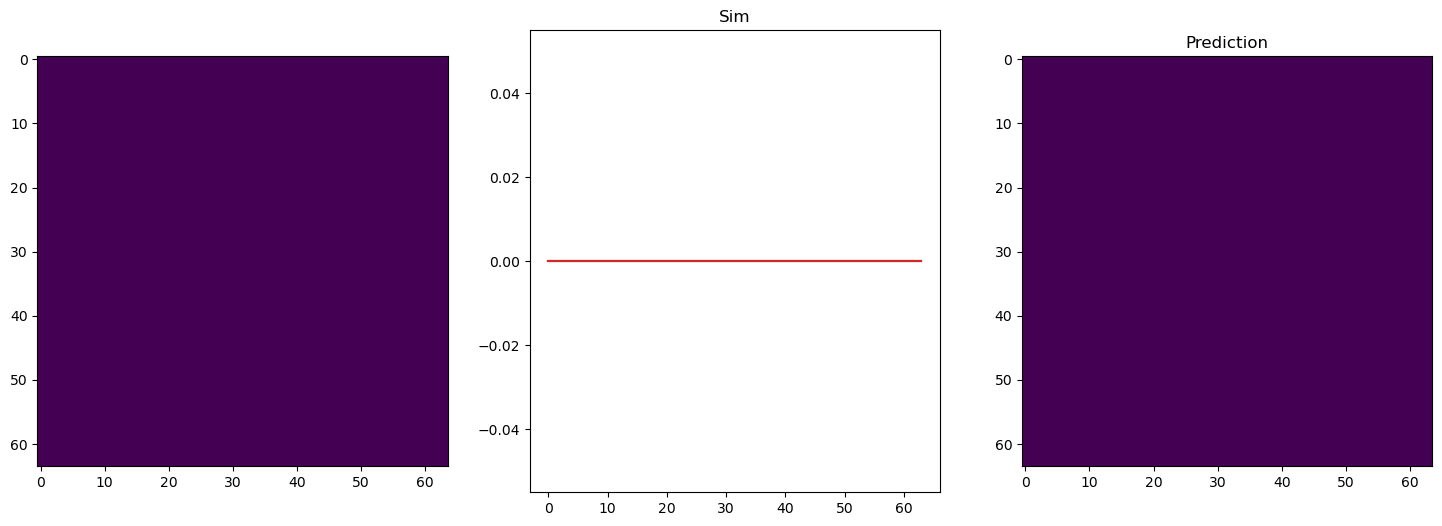

Key_id =  560


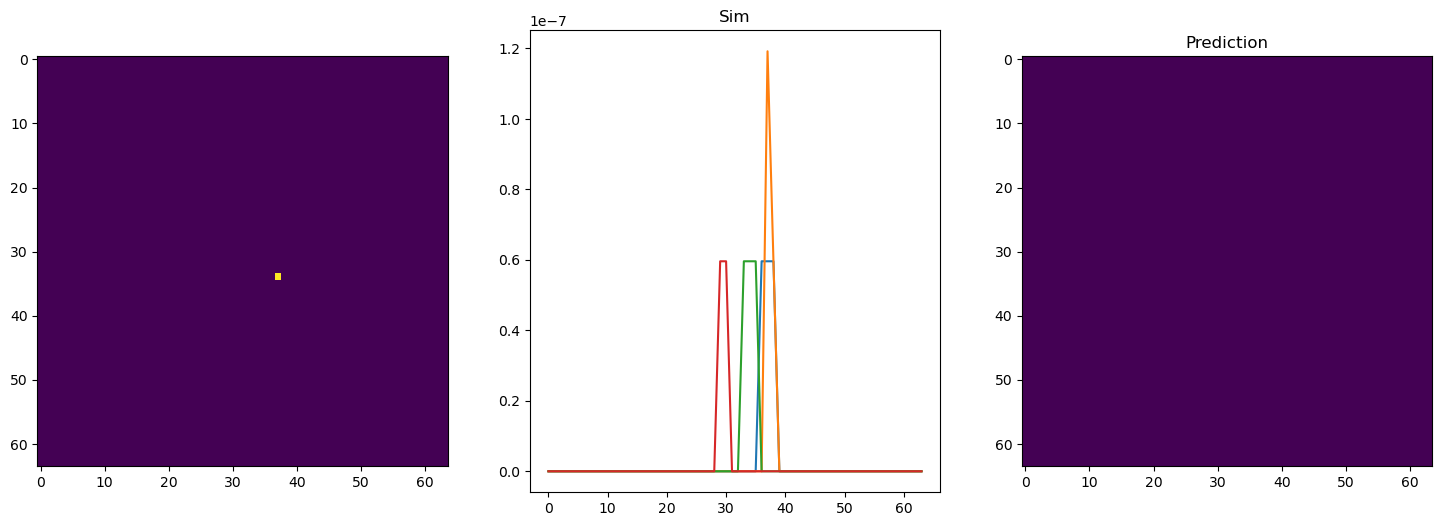

Key_id =  570


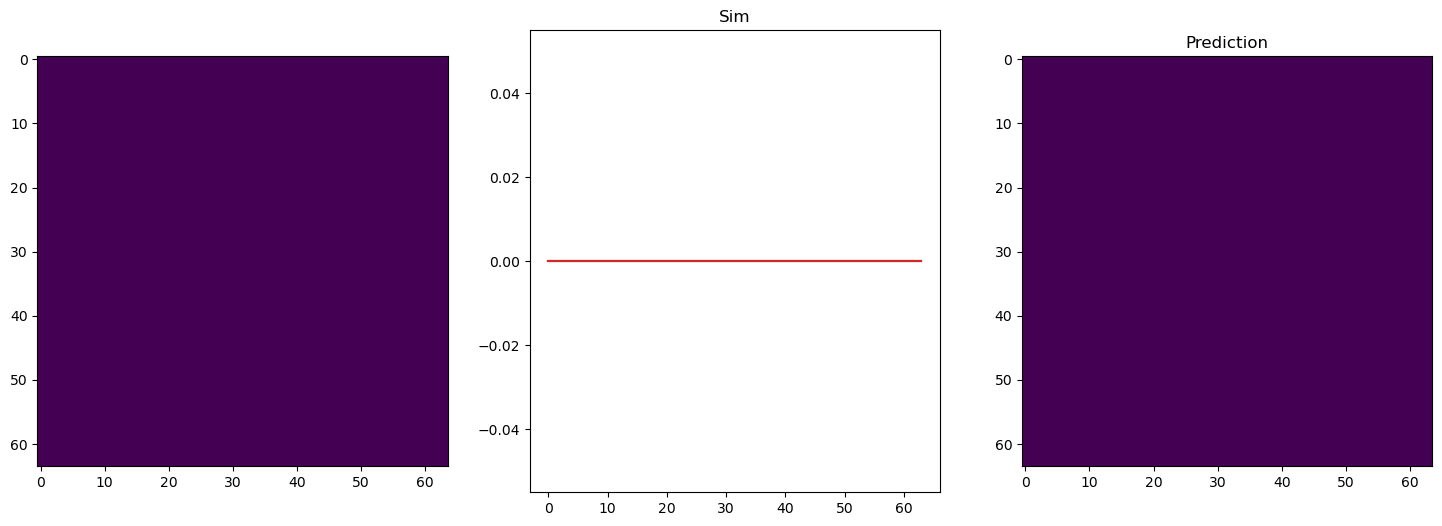

Key_id =  580


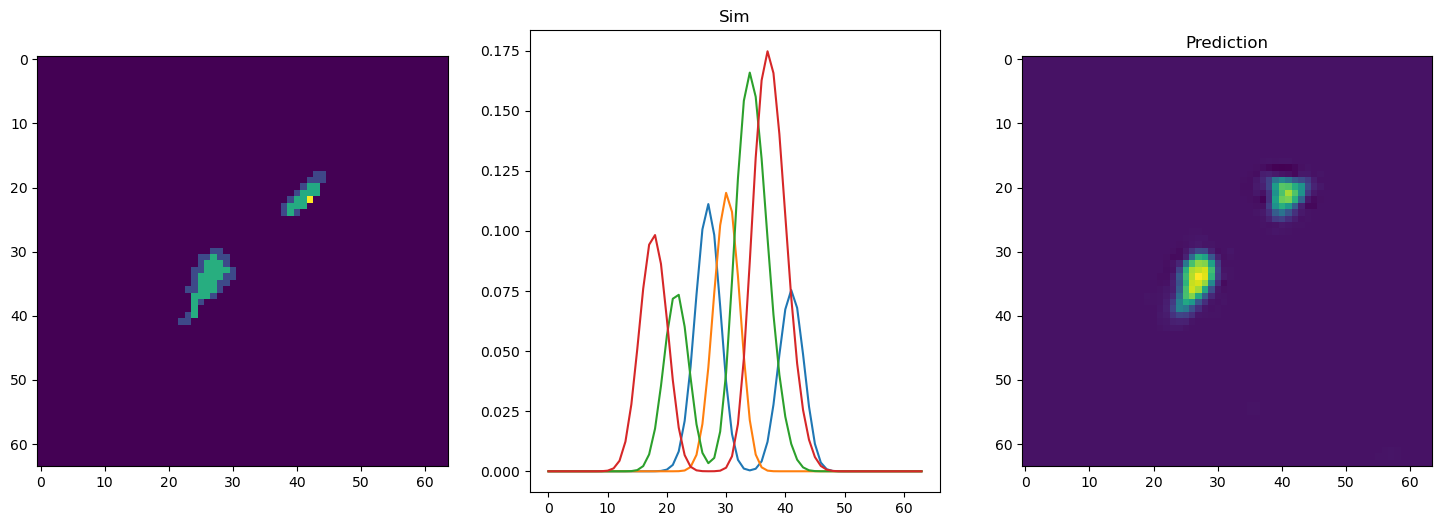

Key_id =  590


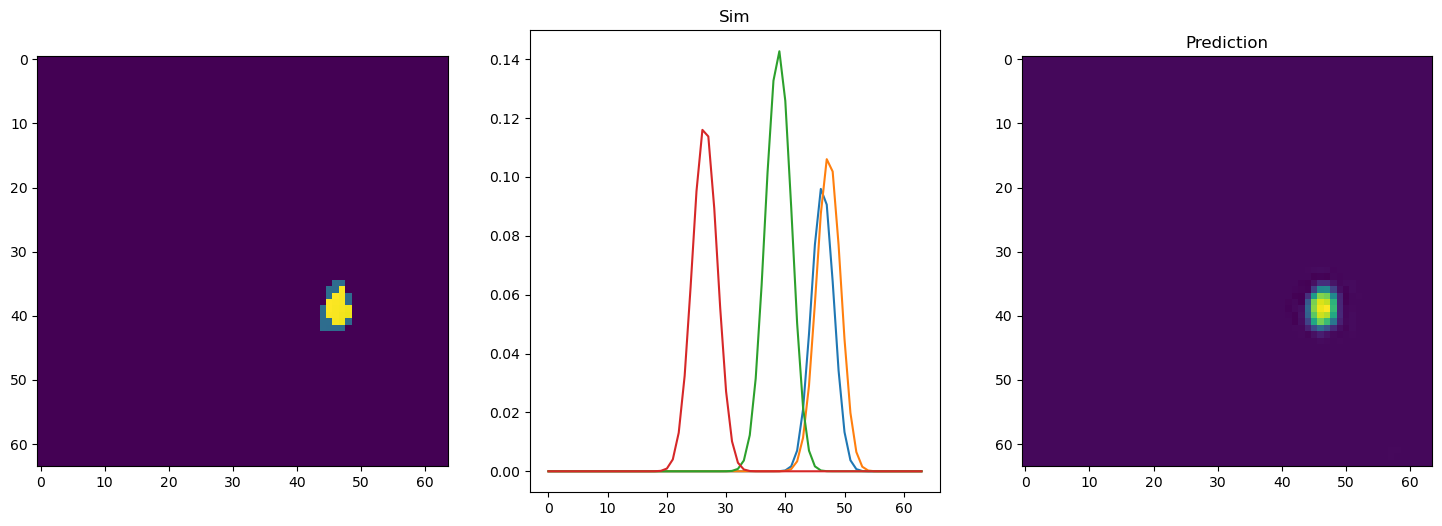

Key_id =  600


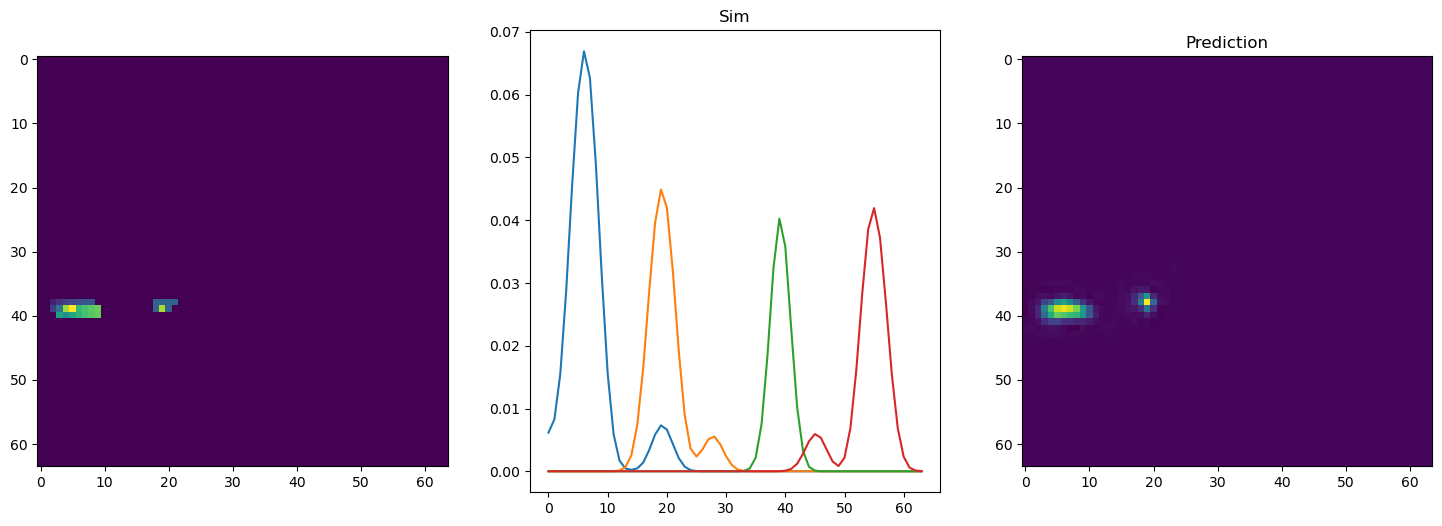

Key_id =  610


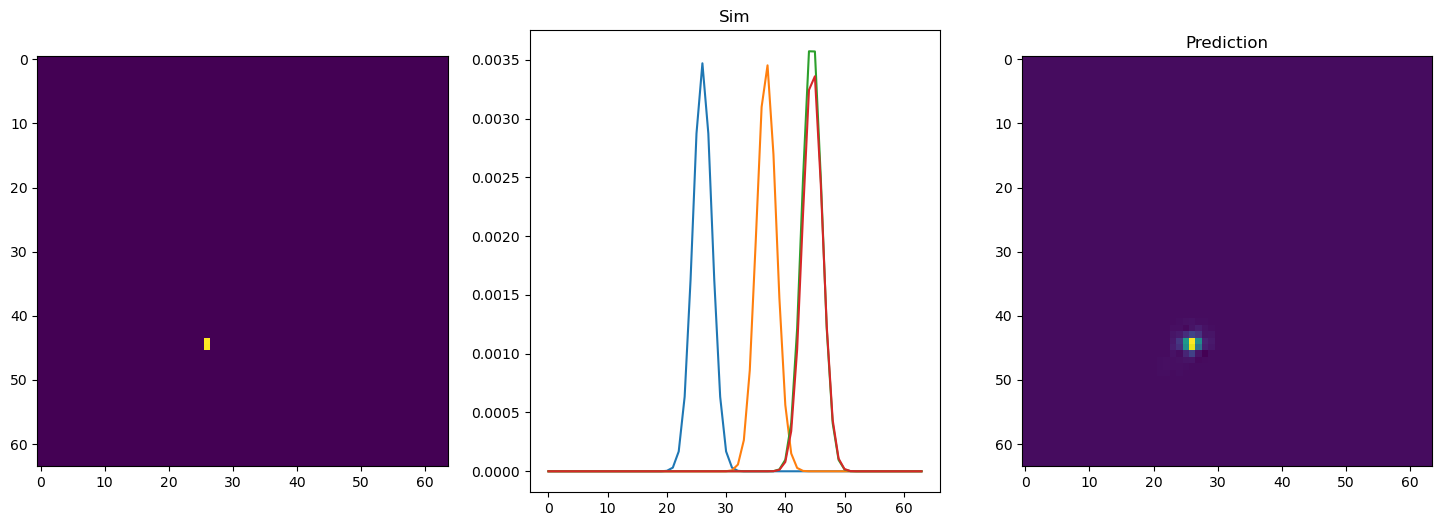

Key_id =  620


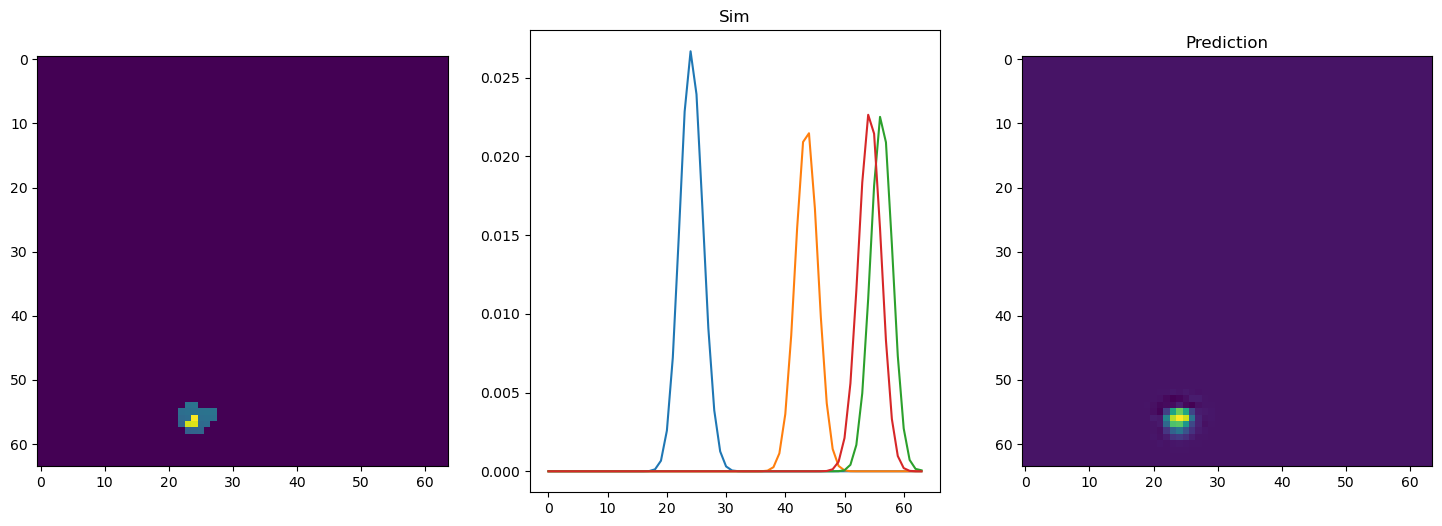

Key_id =  630


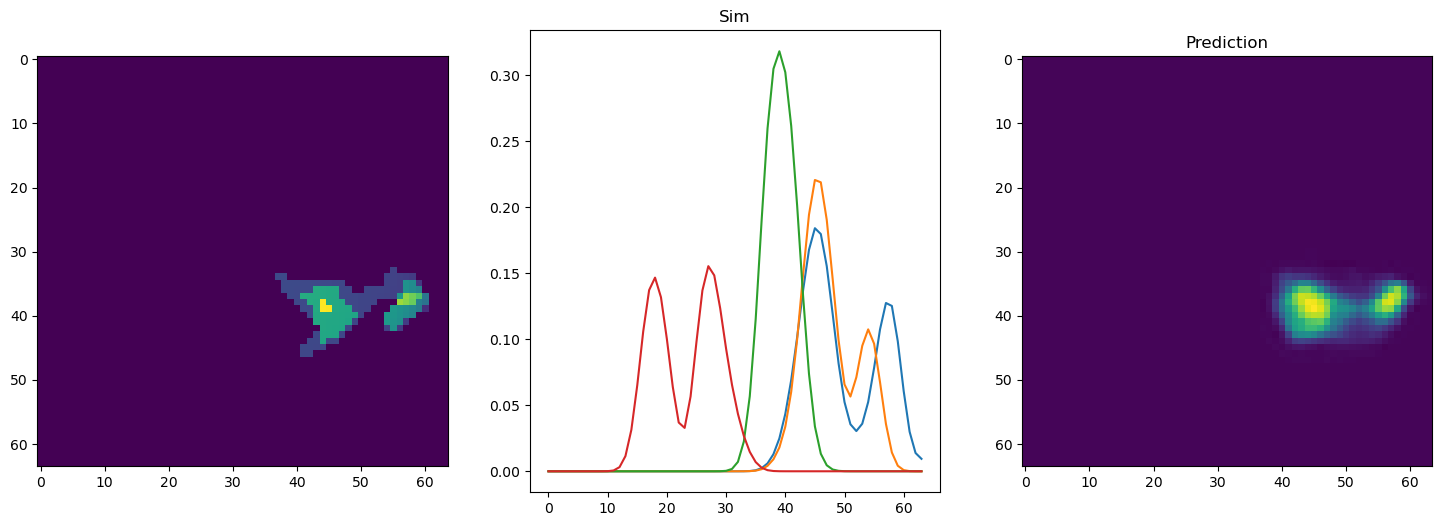

Key_id =  640


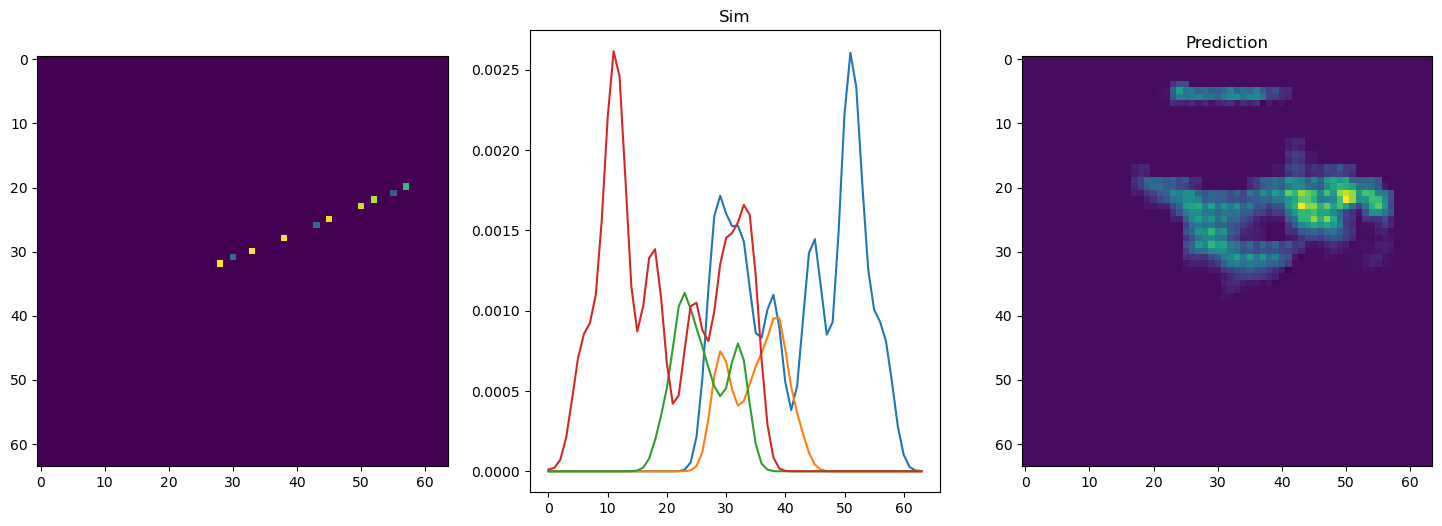

Key_id =  650


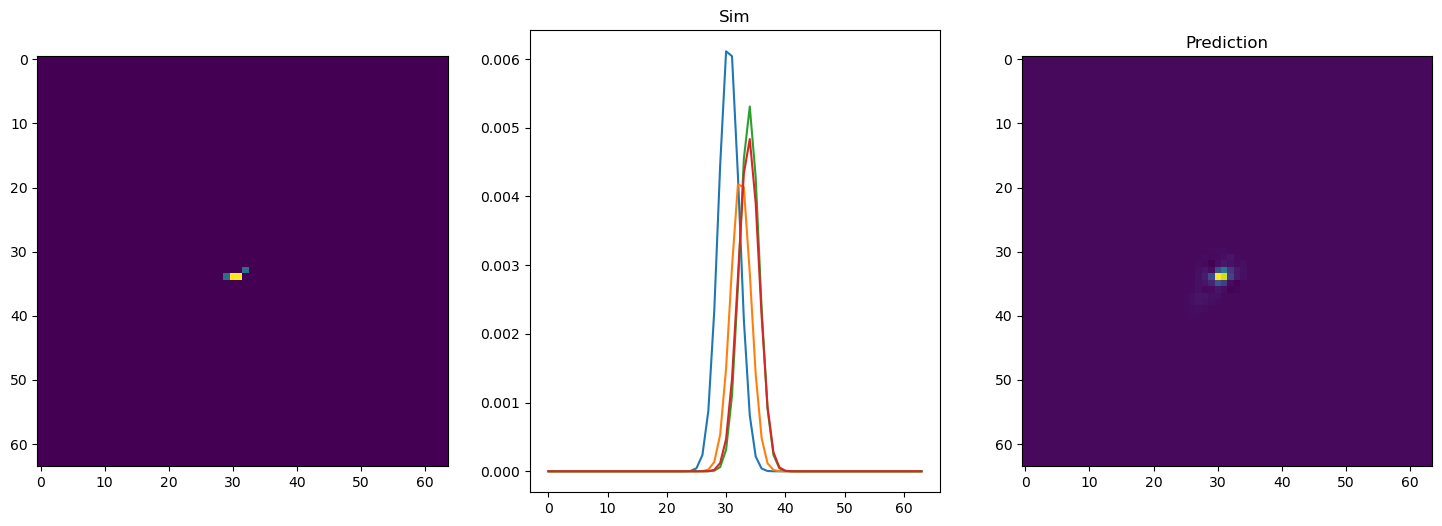

Key_id =  660


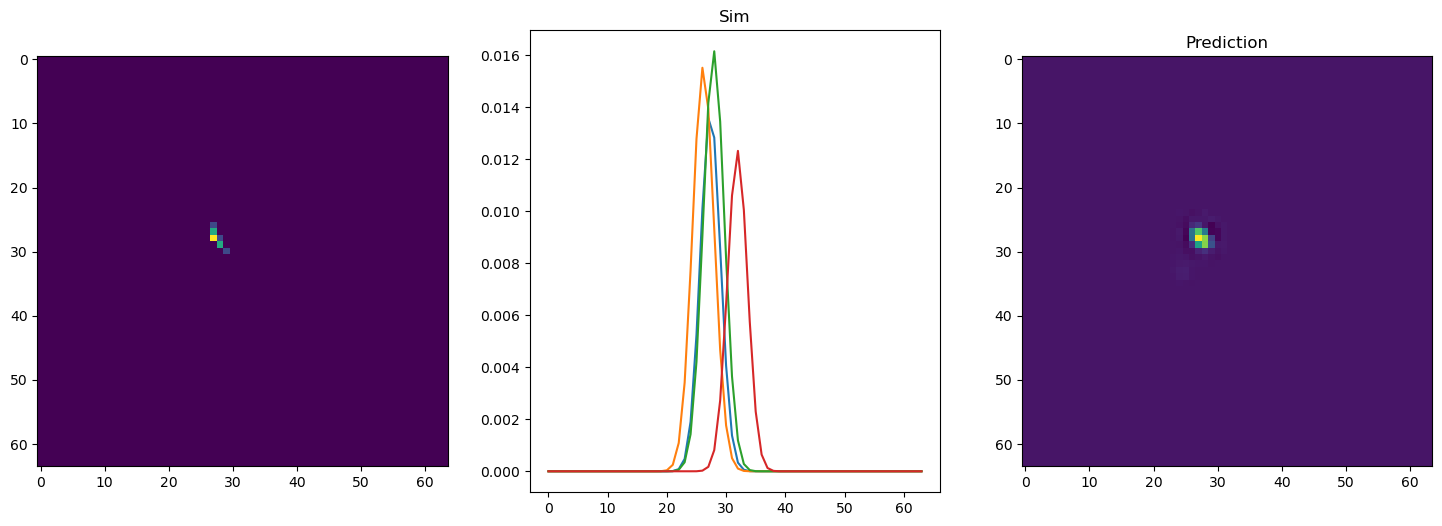

Key_id =  670


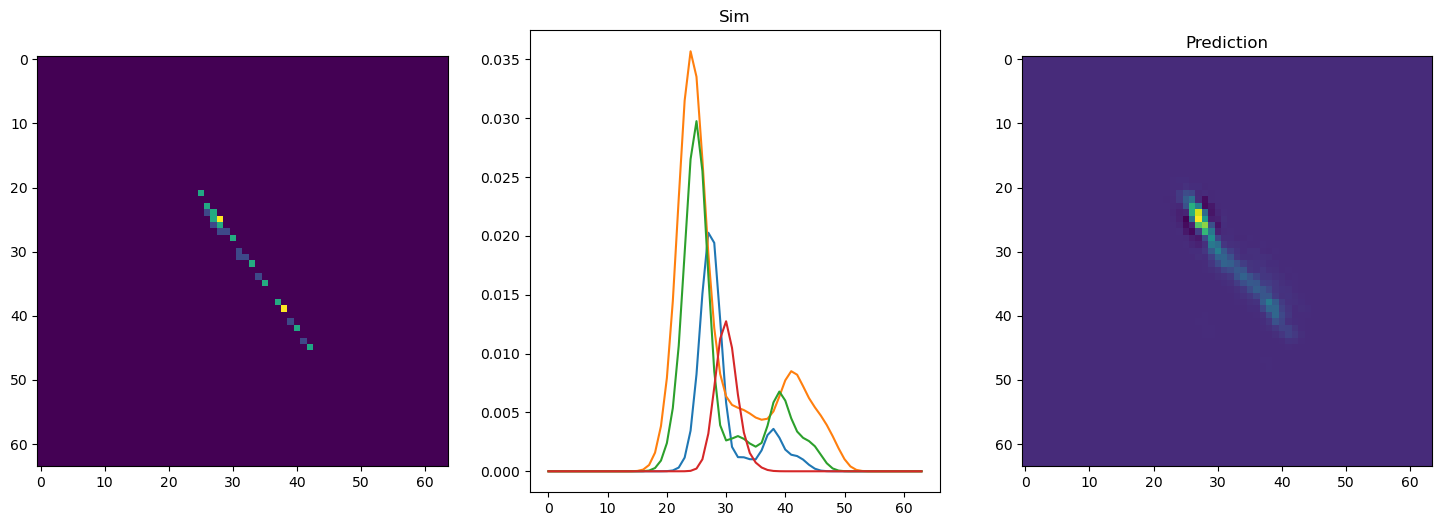

Key_id =  680


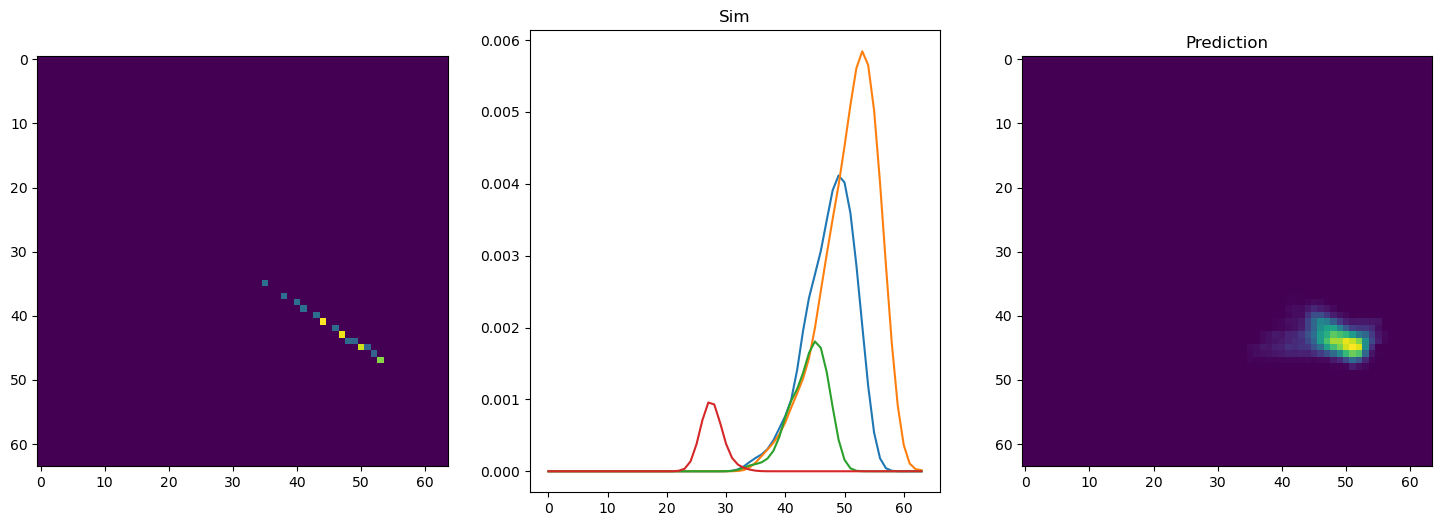

Key_id =  690


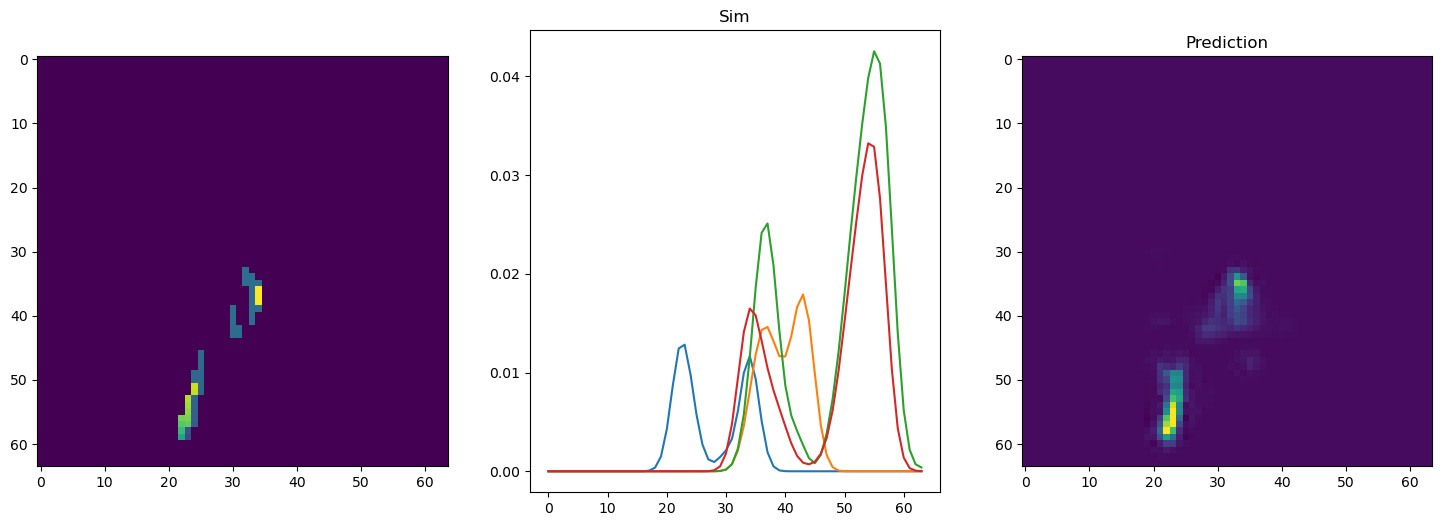

Key_id =  700


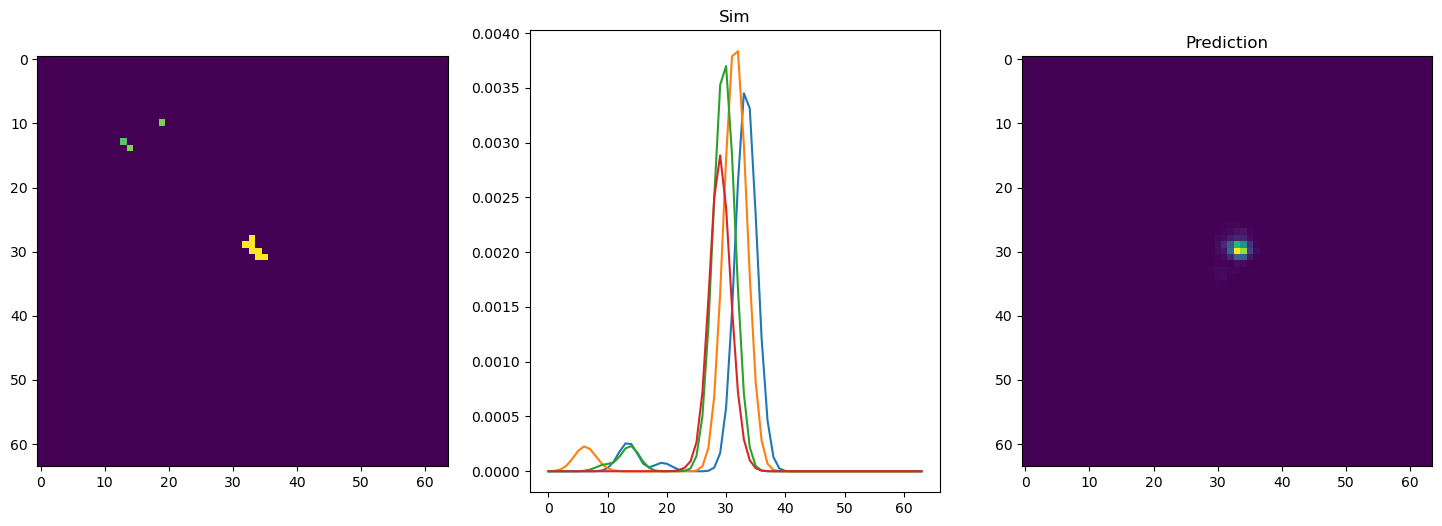

Key_id =  710


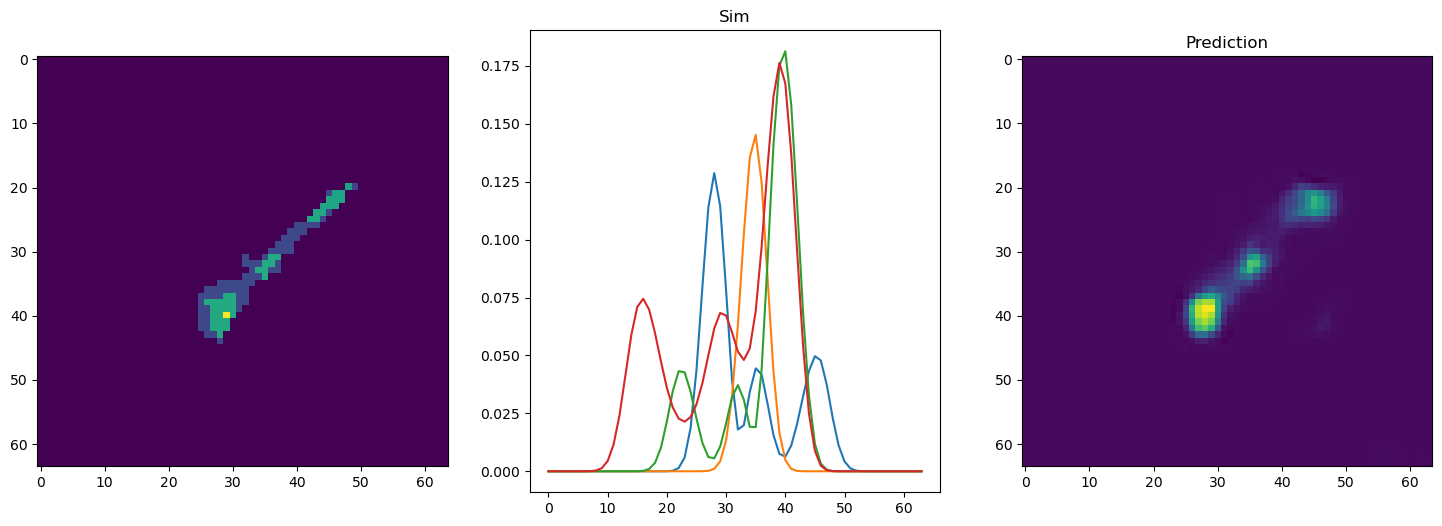

Key_id =  720


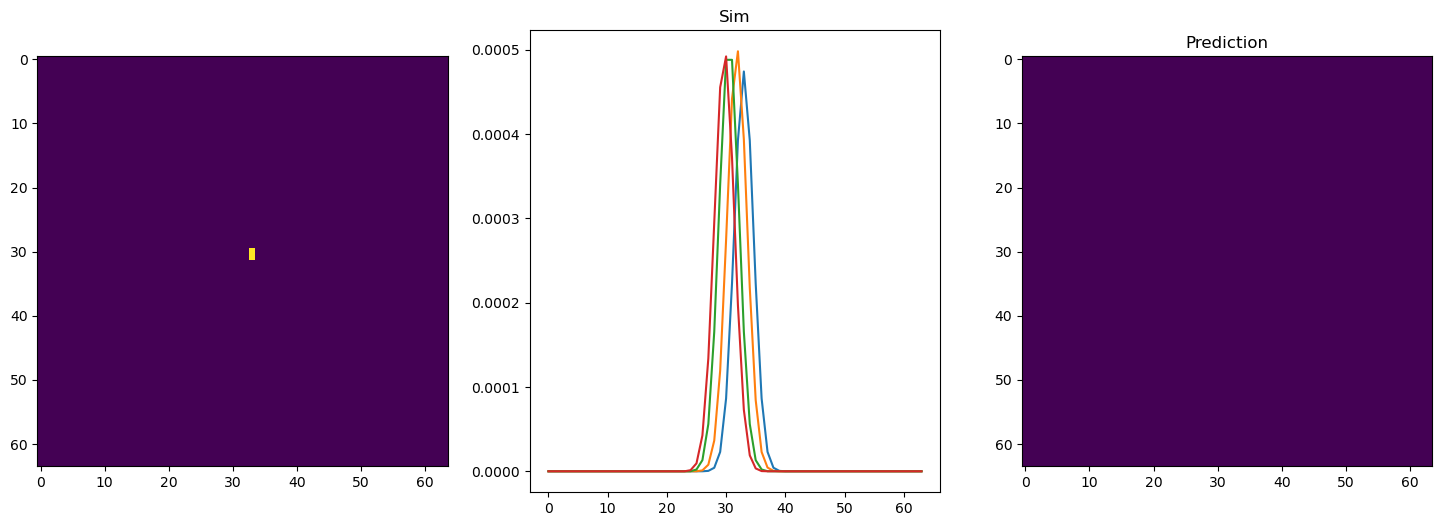

Key_id =  730


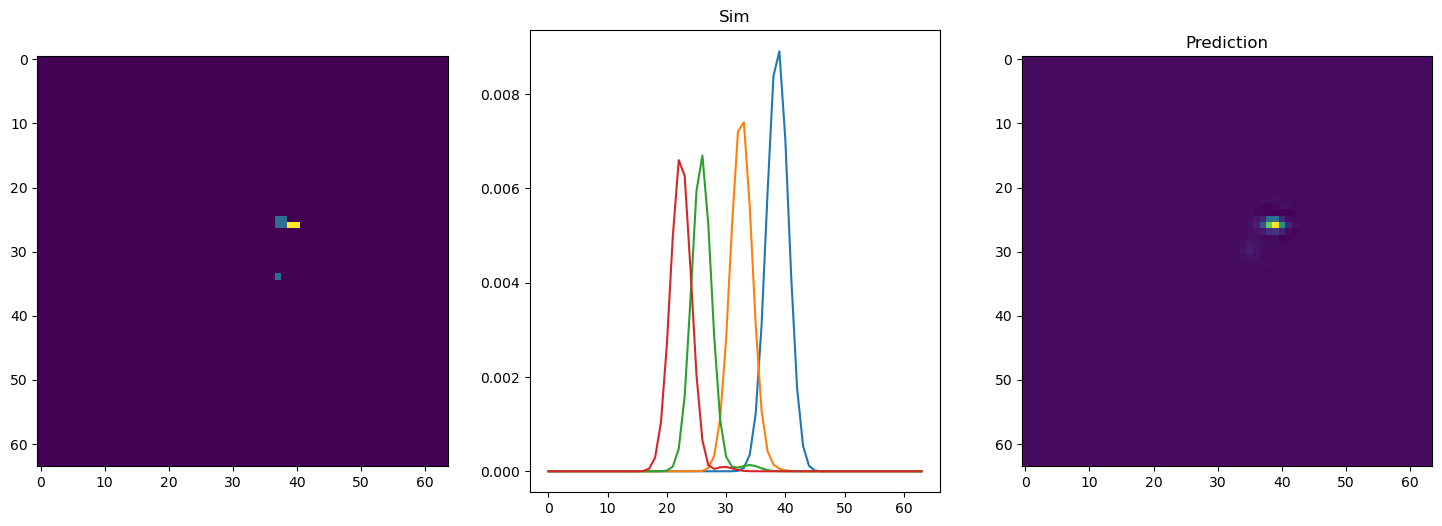

Key_id =  740


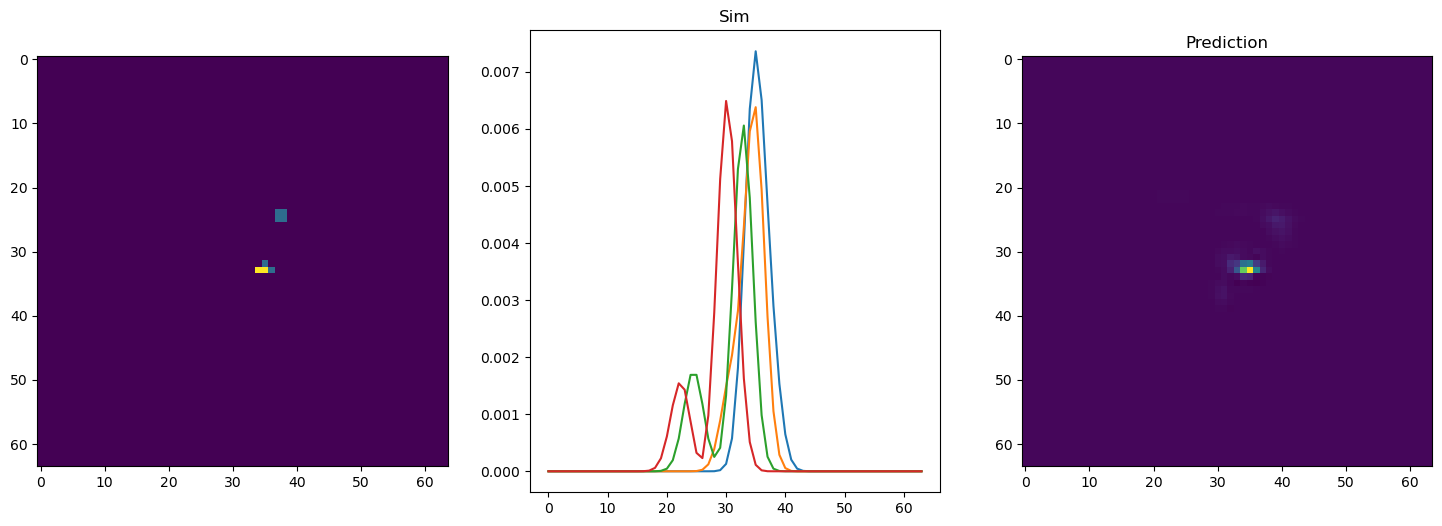

Key_id =  750


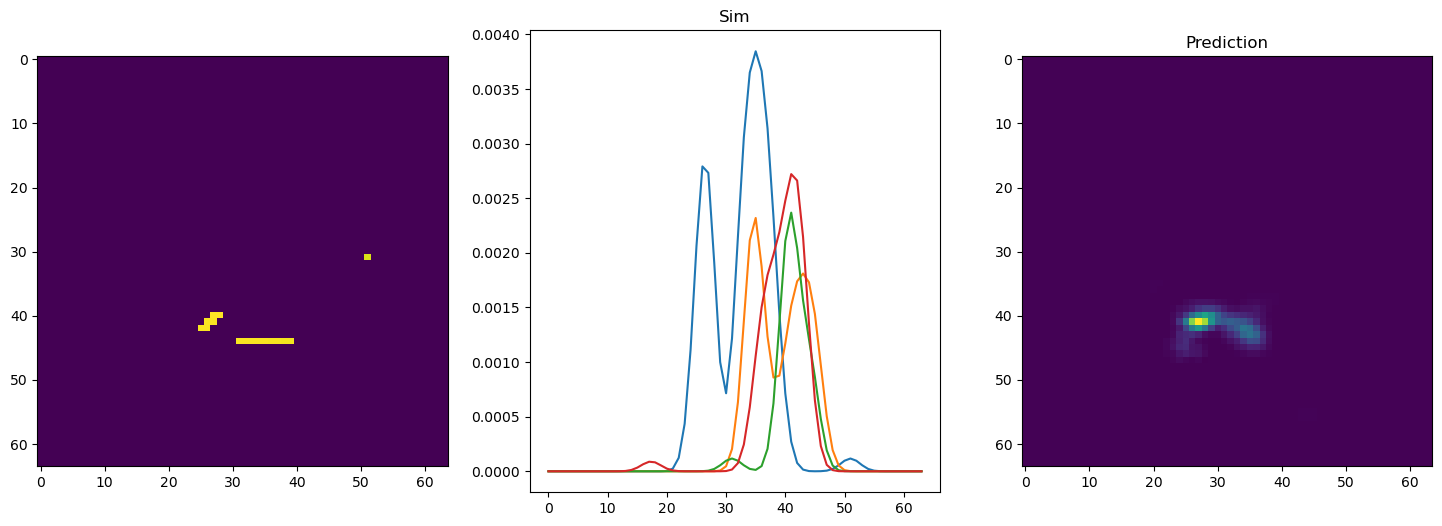

Key_id =  760


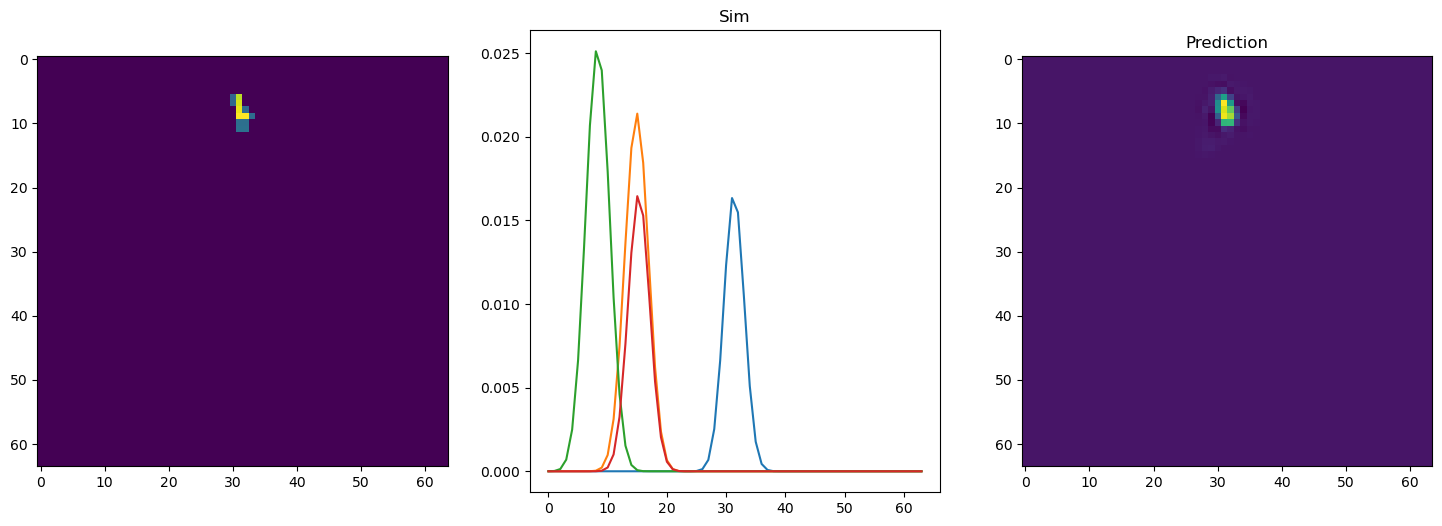

Key_id =  770


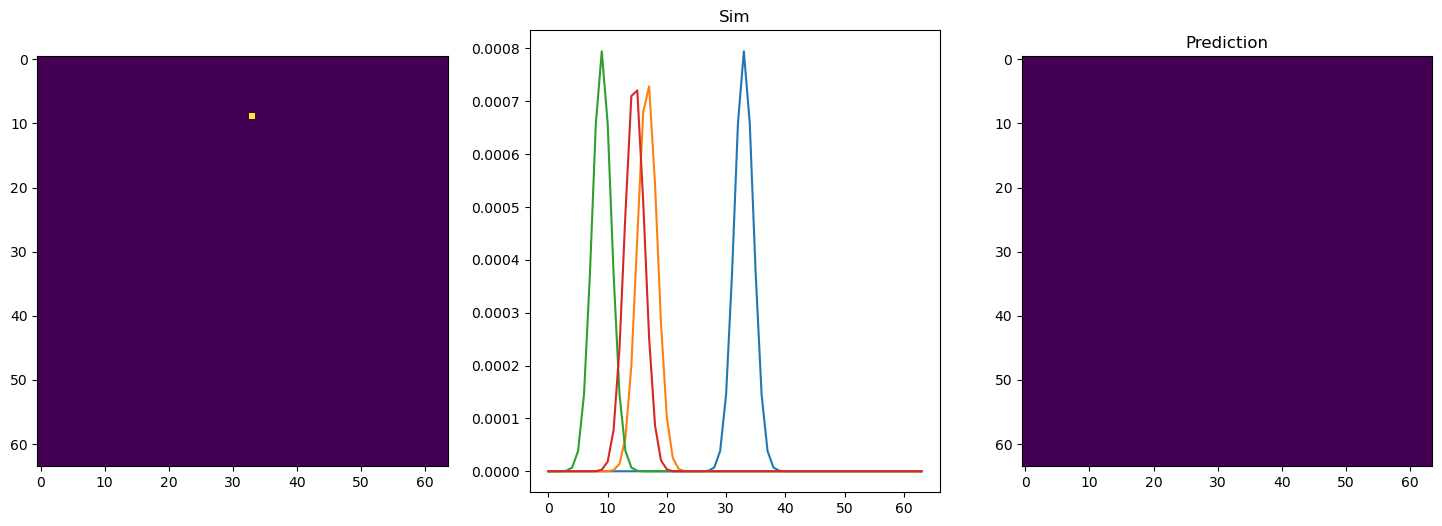

Key_id =  780


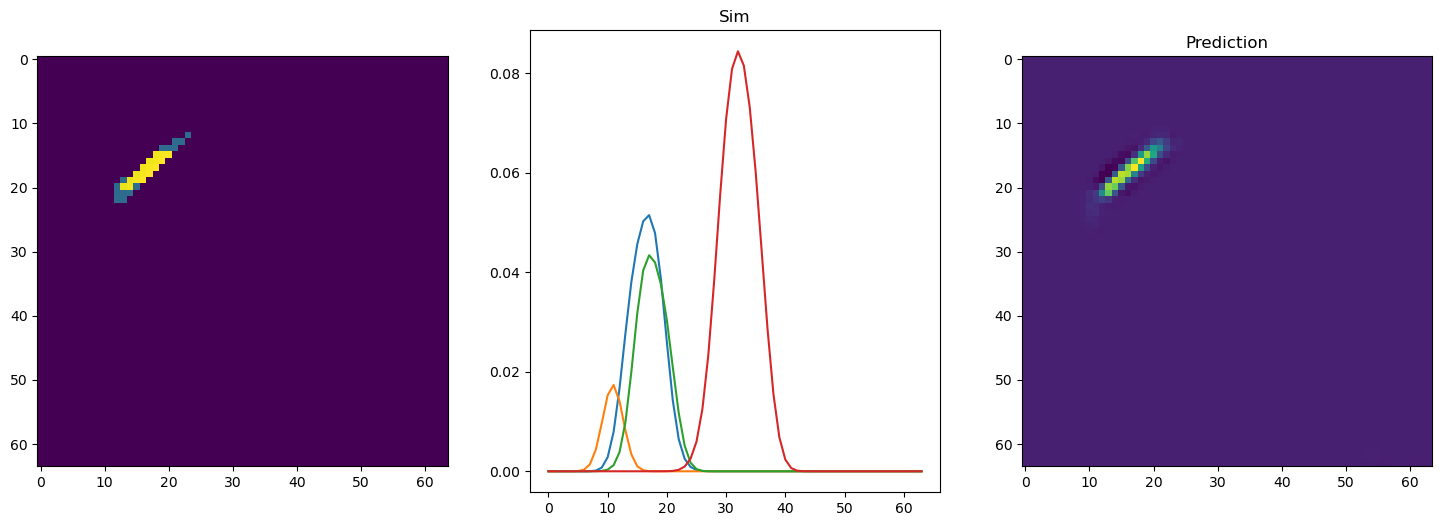

Key_id =  790


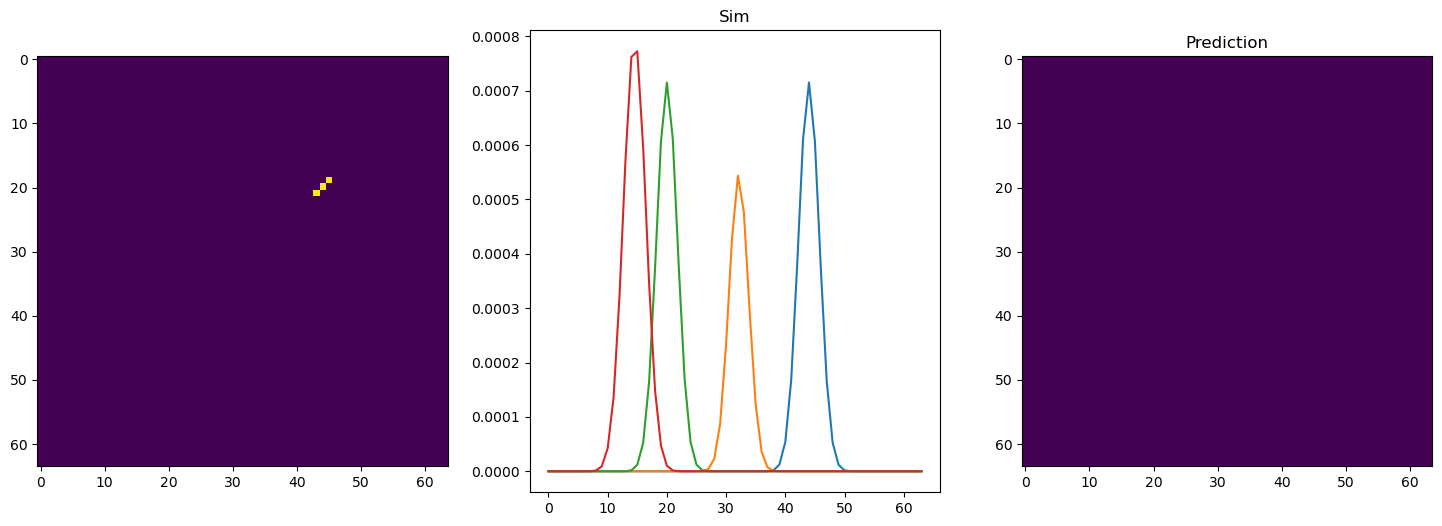

Key_id =  800


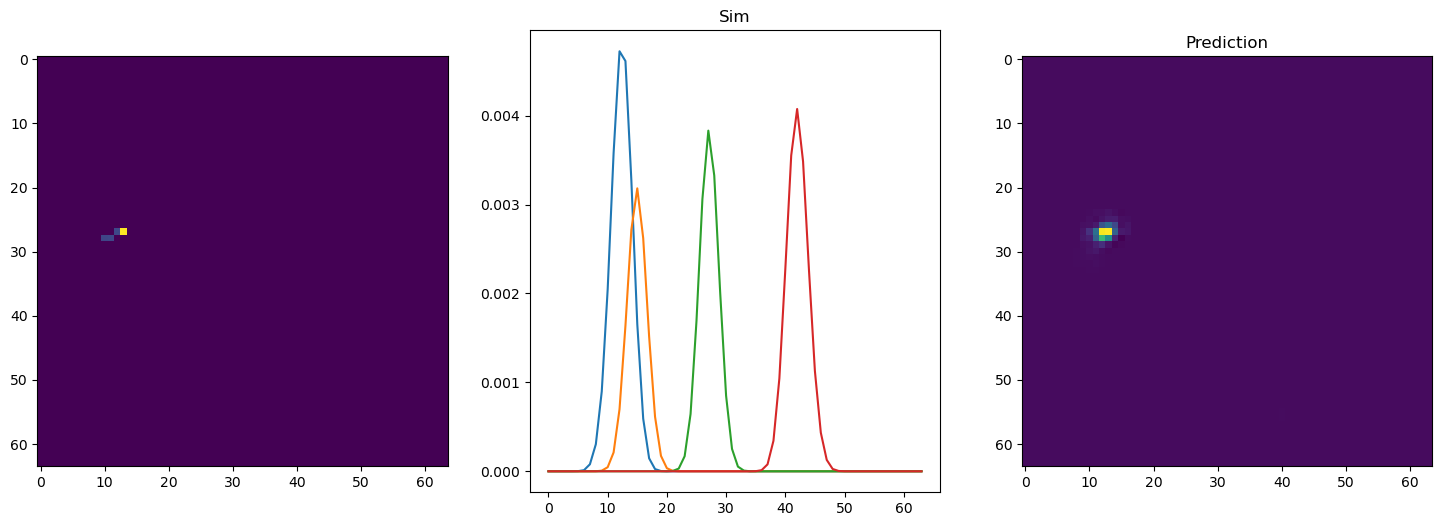

Key_id =  810


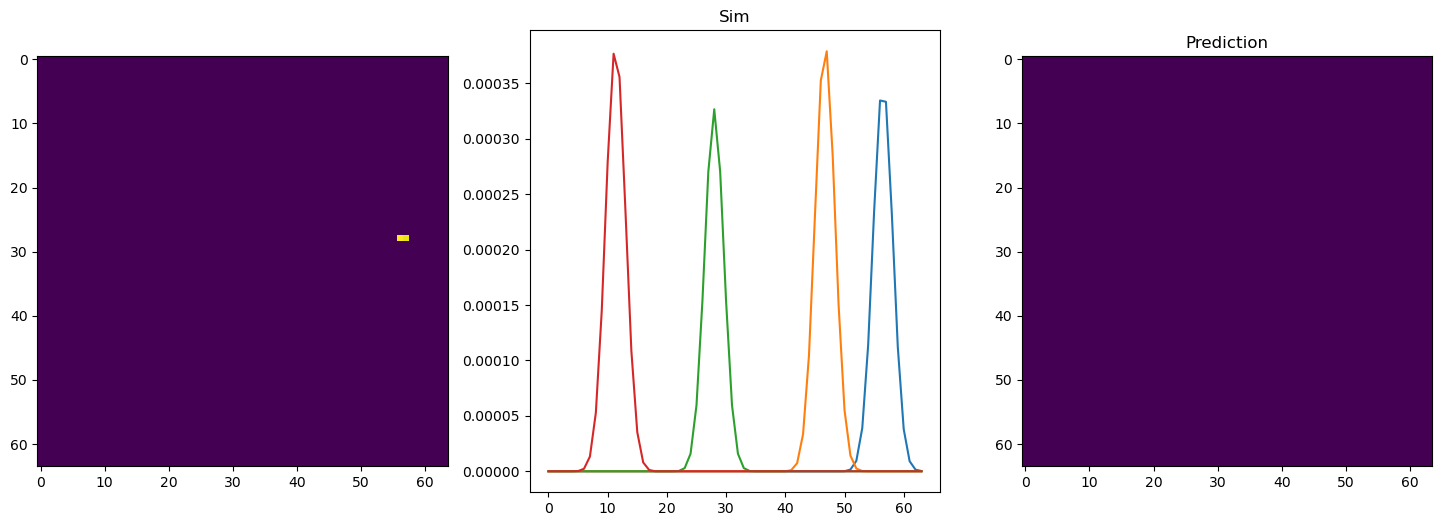

Key_id =  820


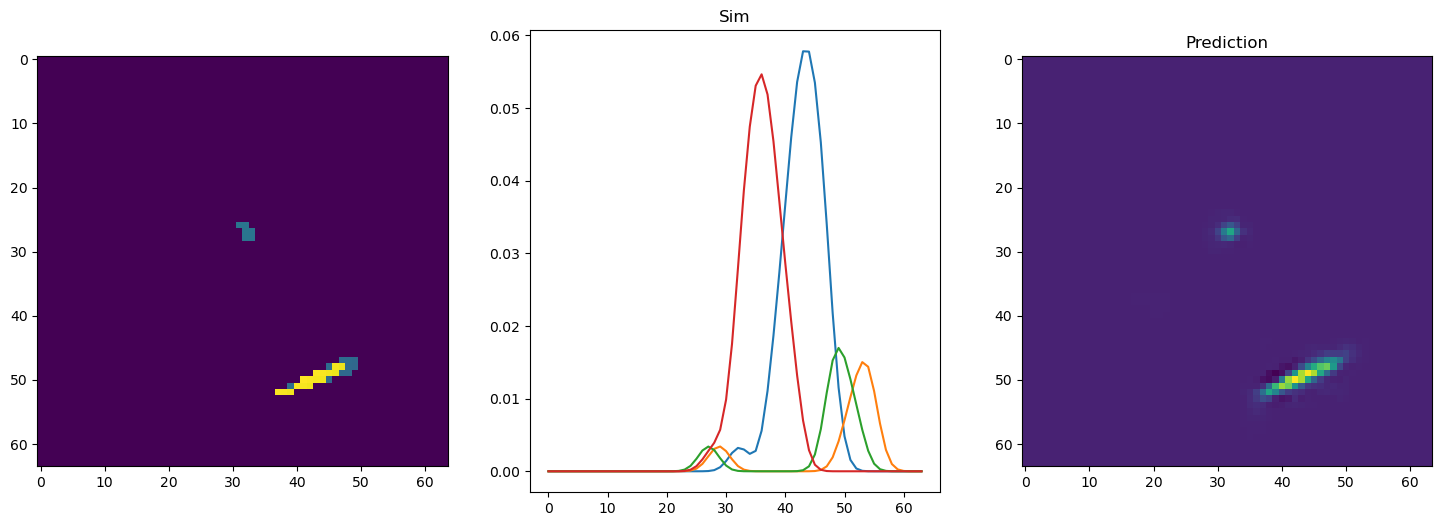

Key_id =  830


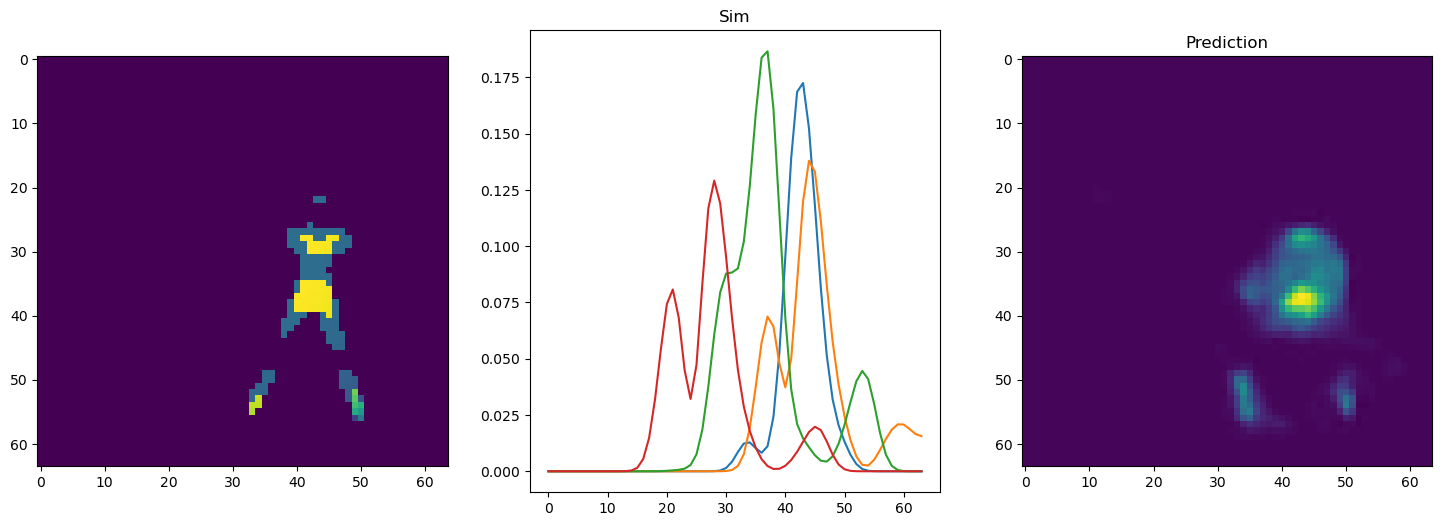

Key_id =  840


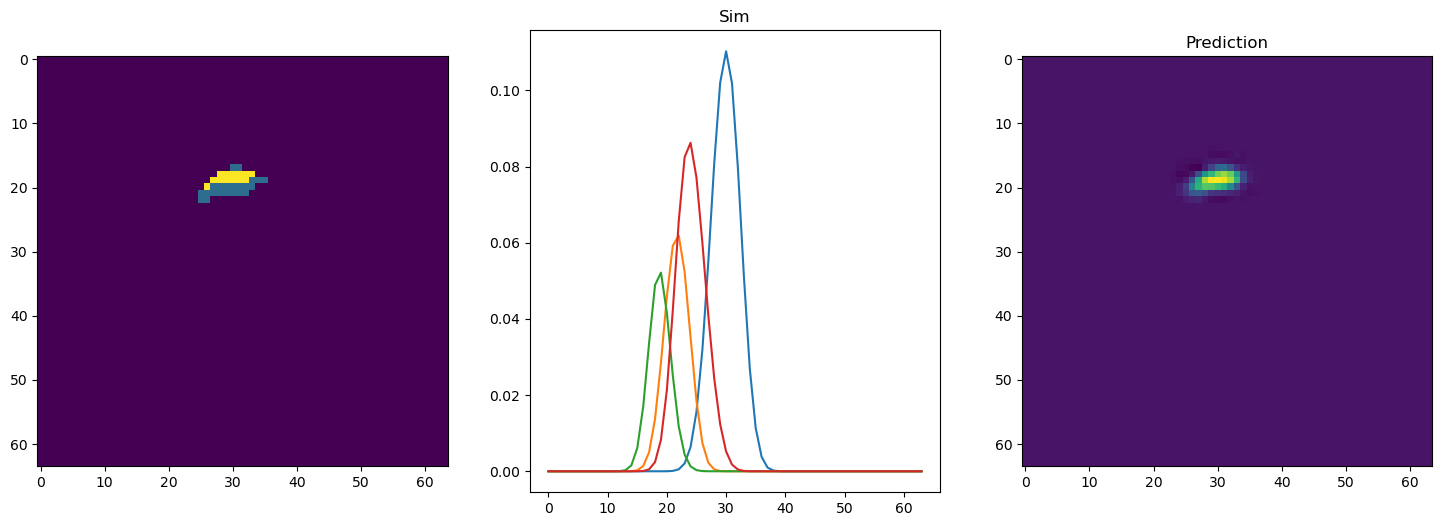

Key_id =  850


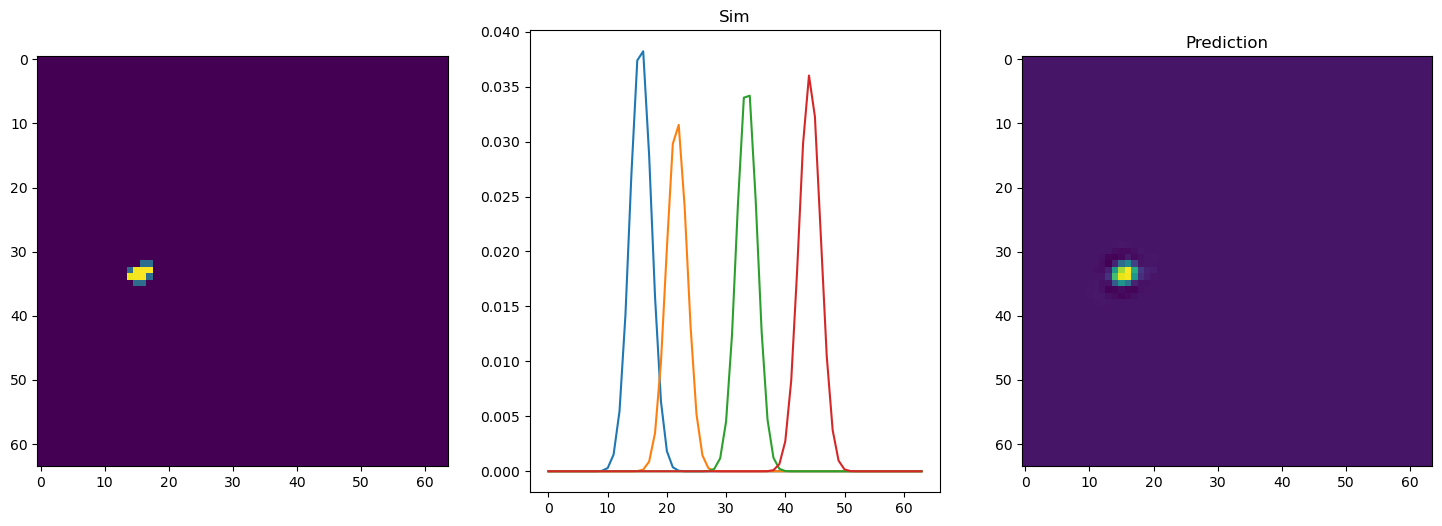

Key_id =  860


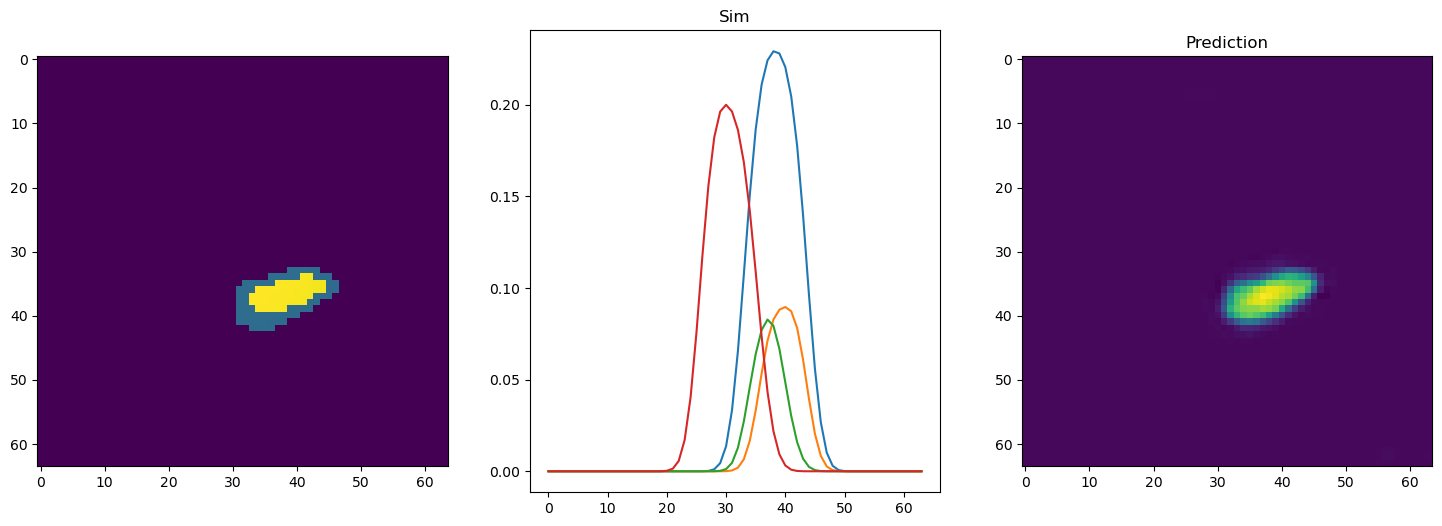

Key_id =  870


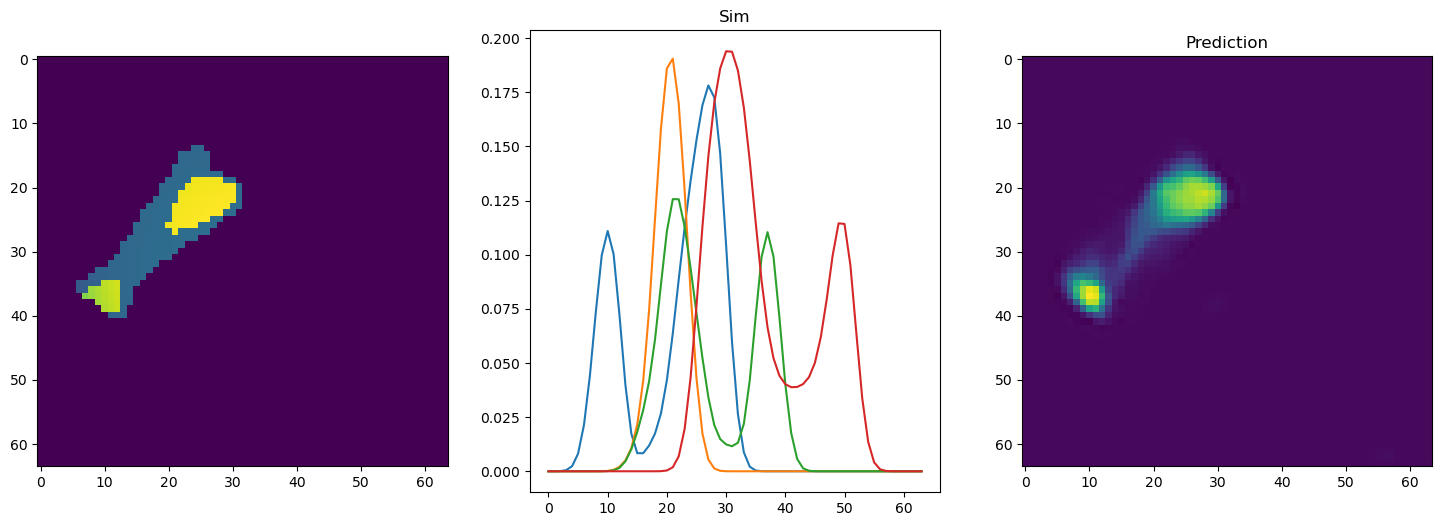

Key_id =  880


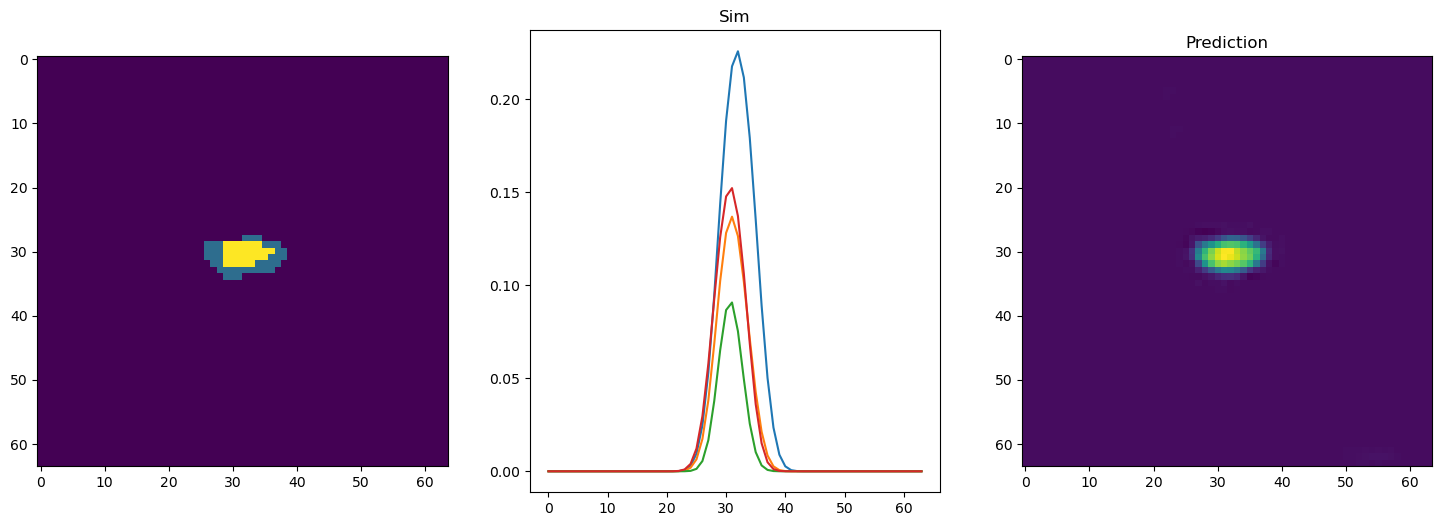

Key_id =  890


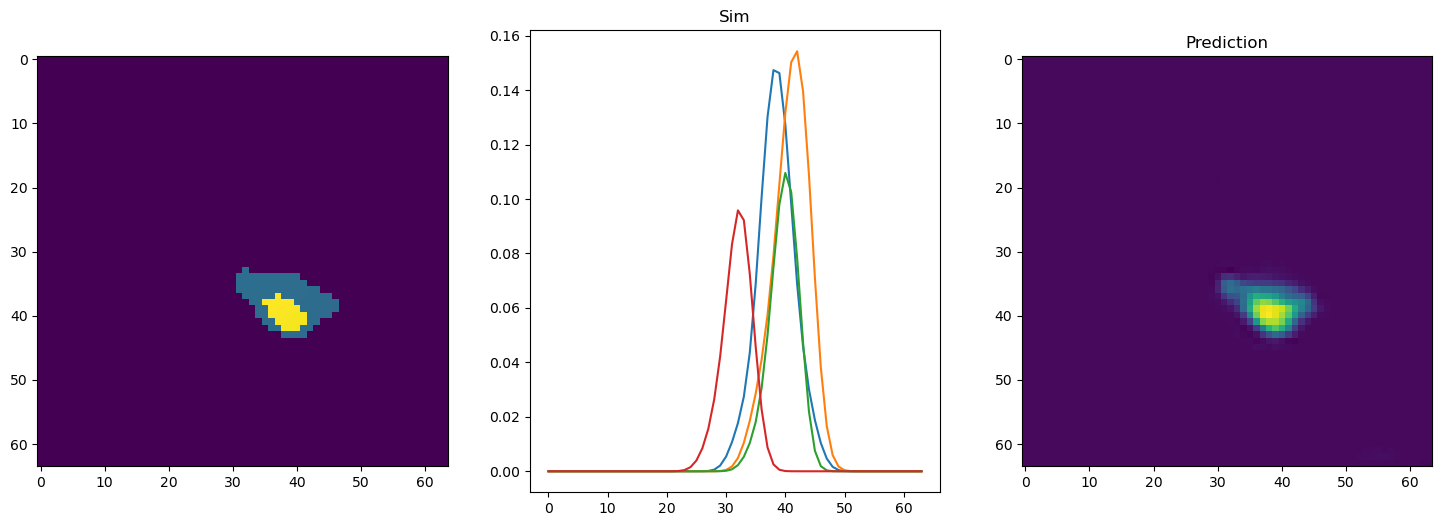

Key_id =  900


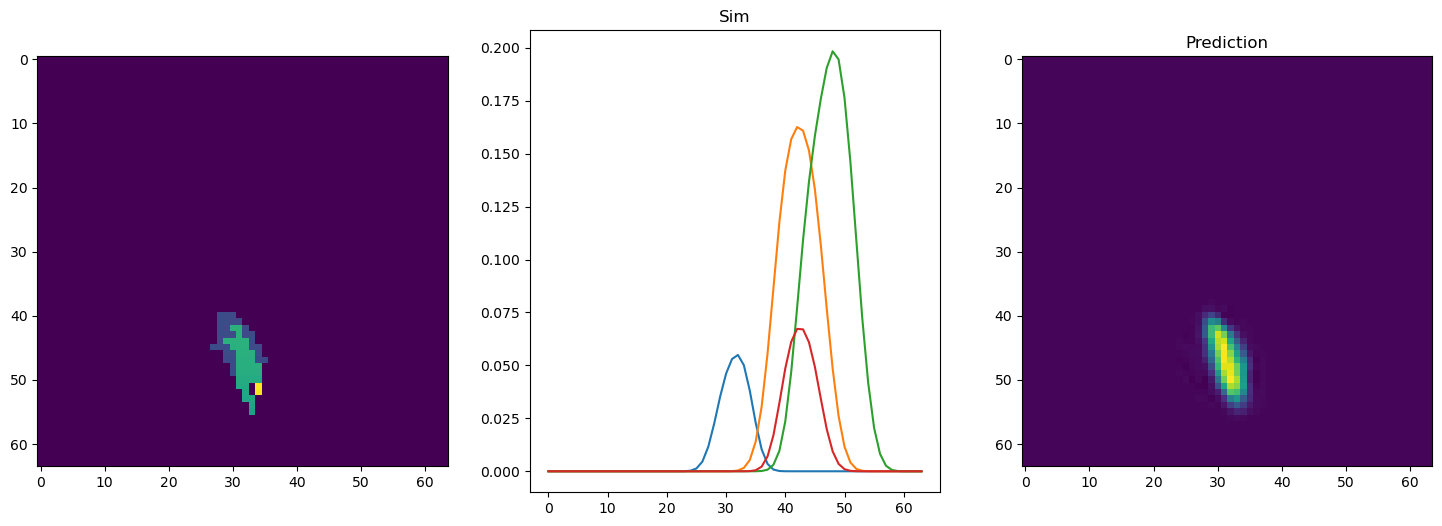

Key_id =  910


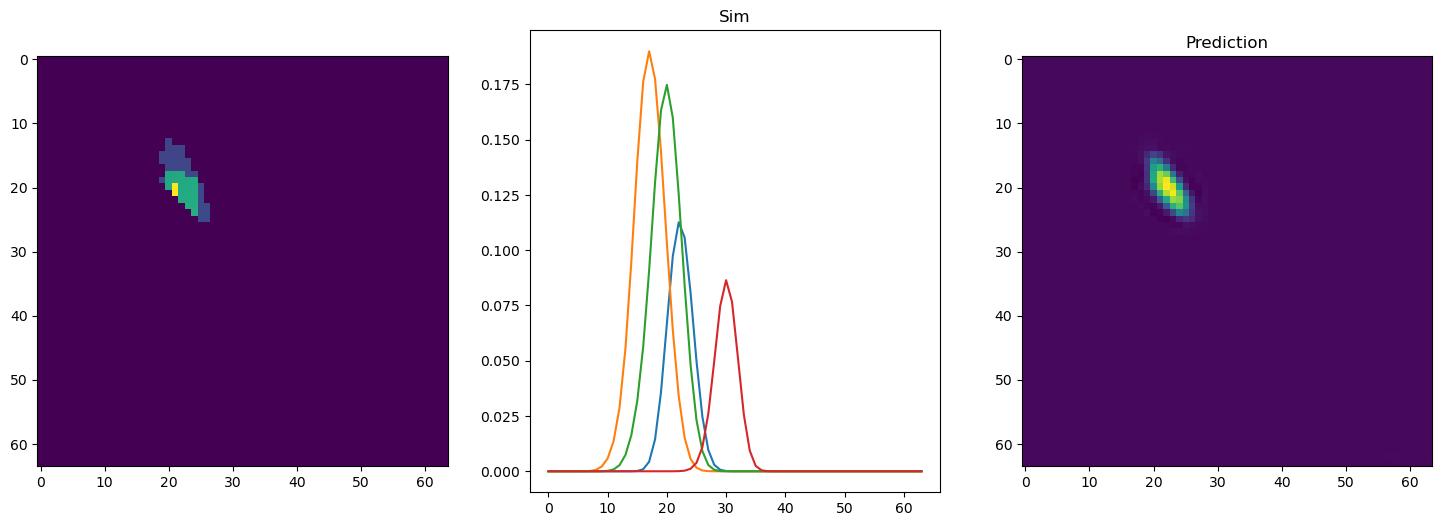

Key_id =  920


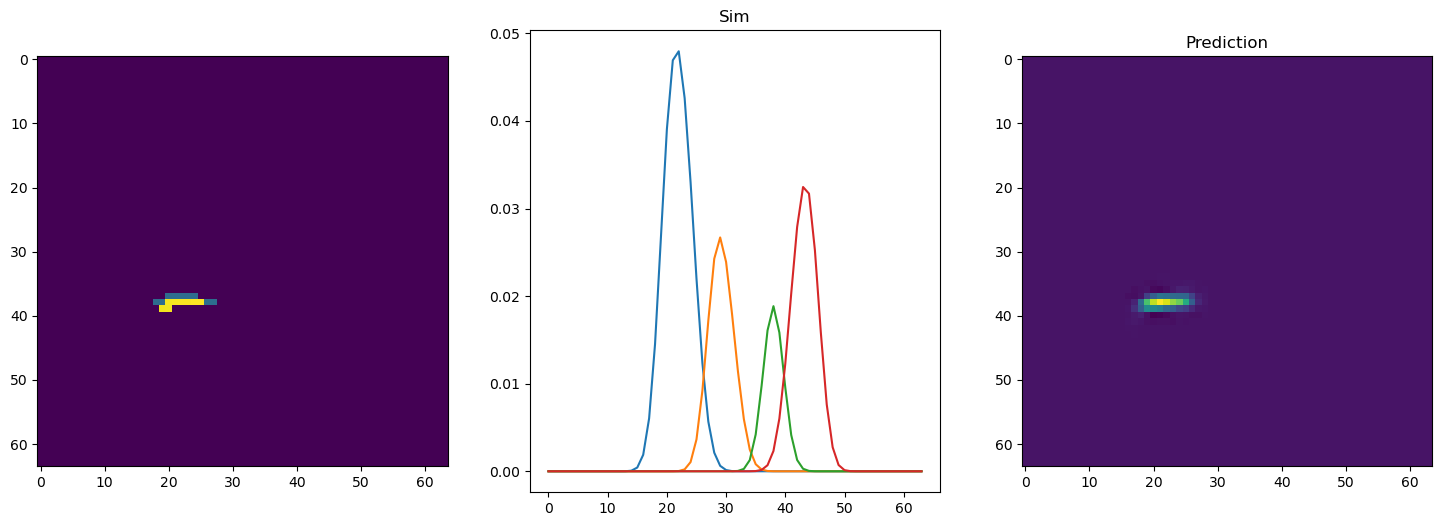

Key_id =  930


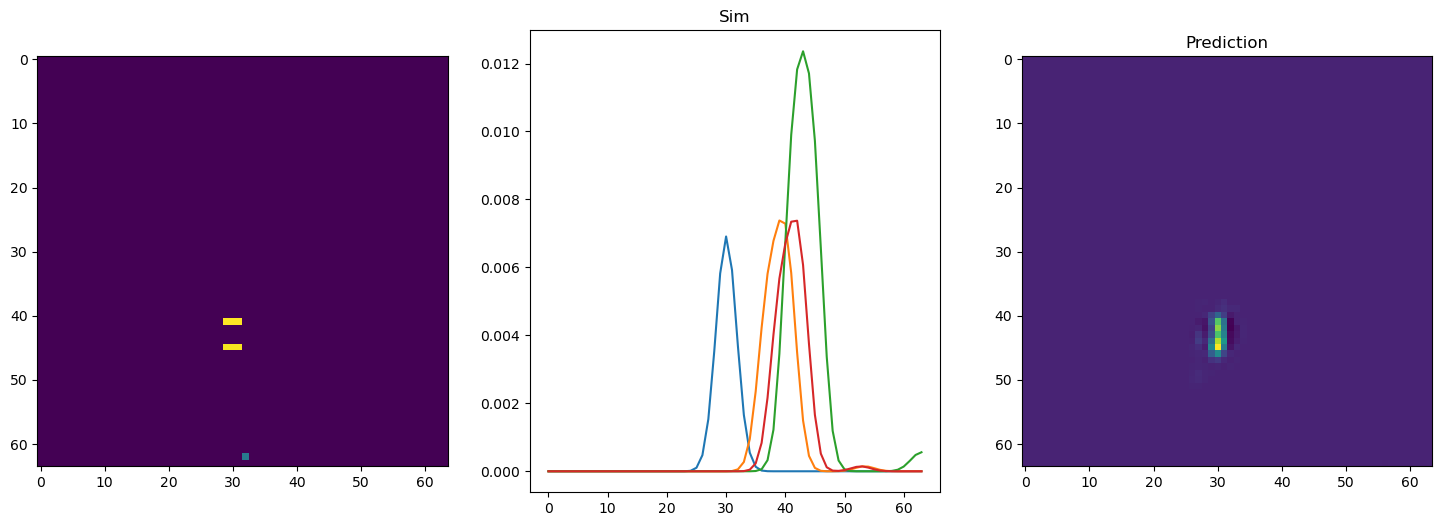

Key_id =  940


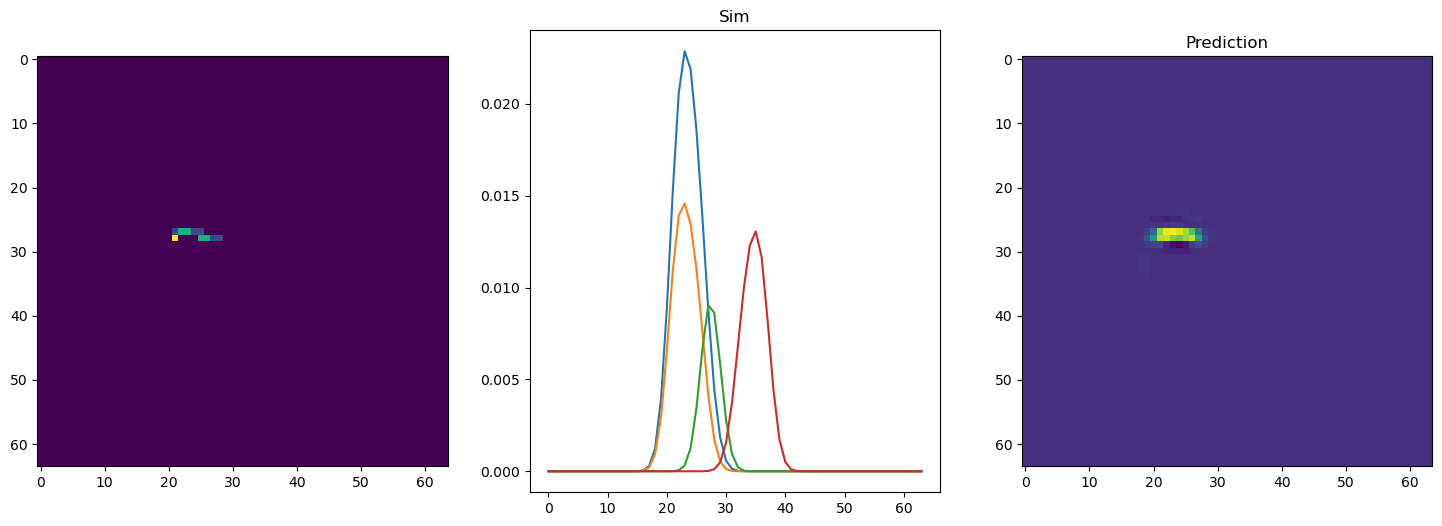

Key_id =  950


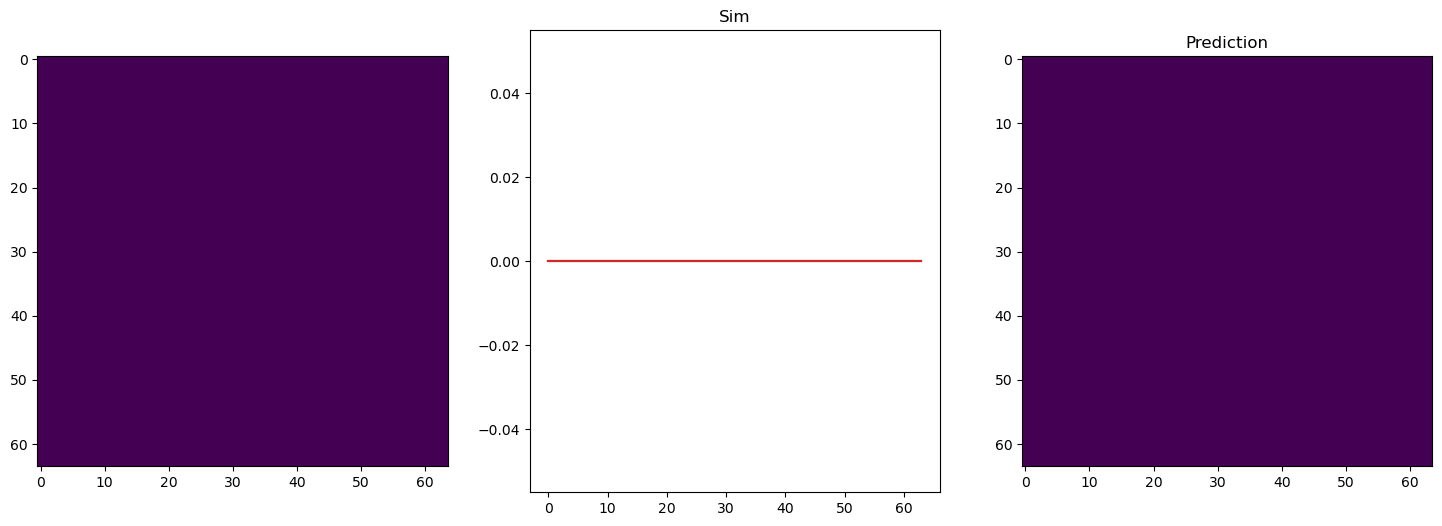

Key_id =  960


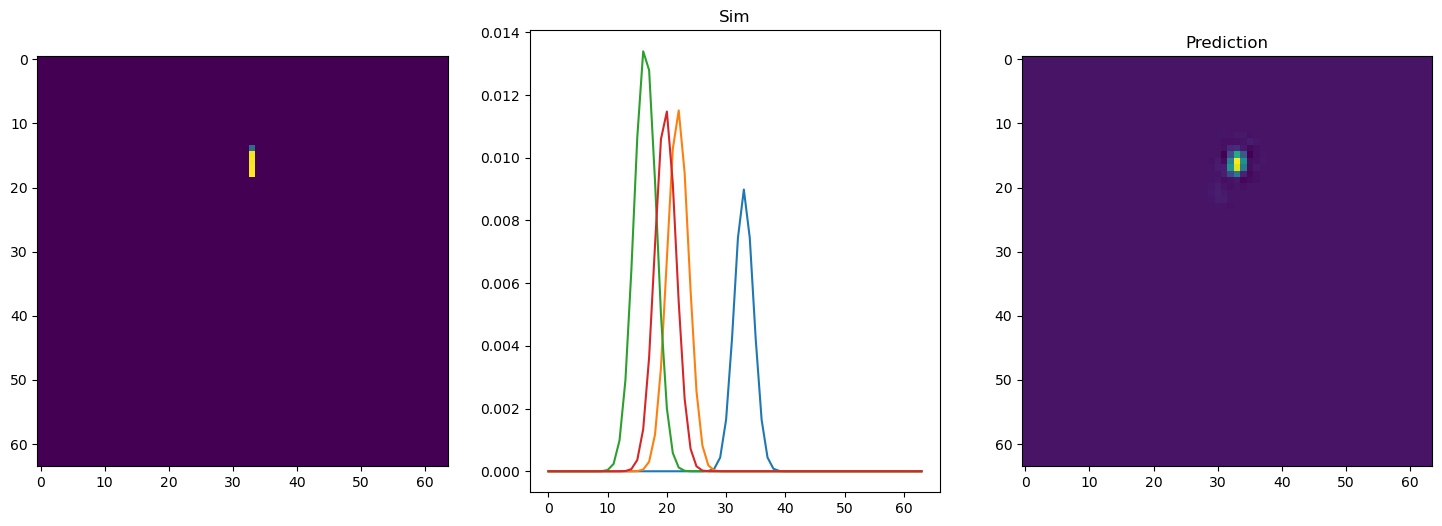

Key_id =  970


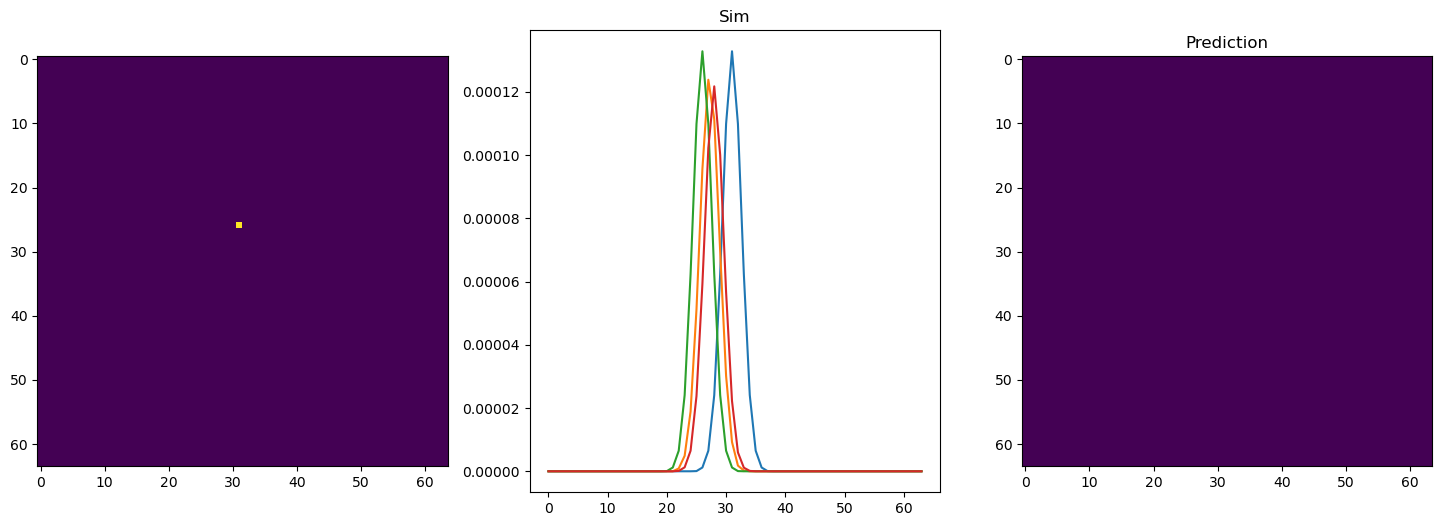

Key_id =  980


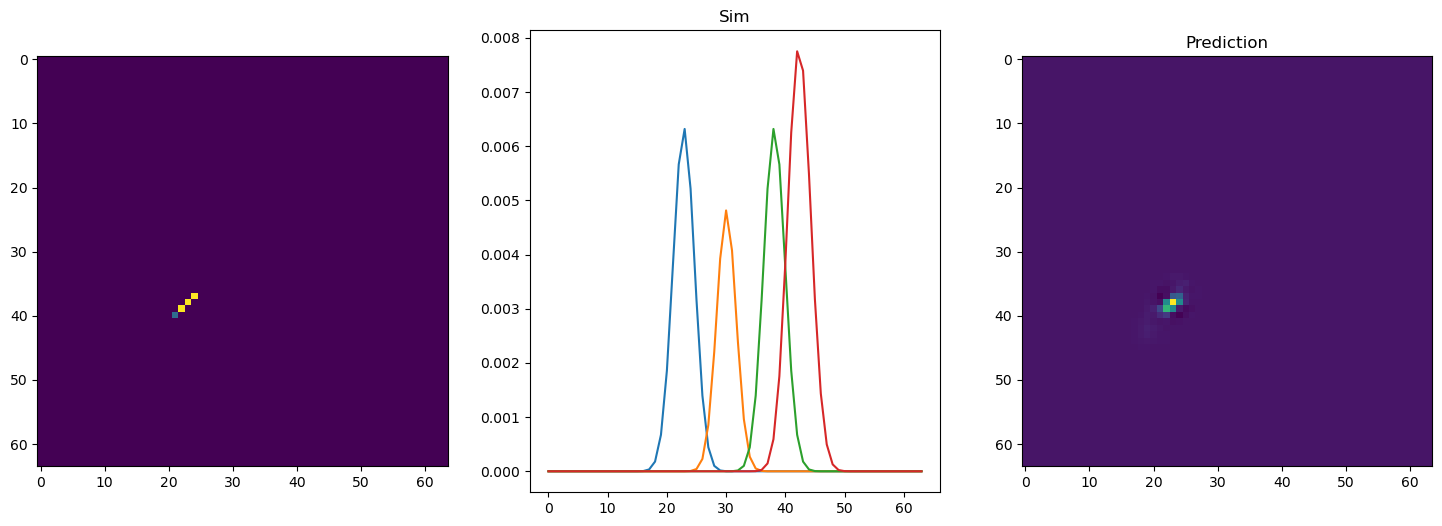

Key_id =  990


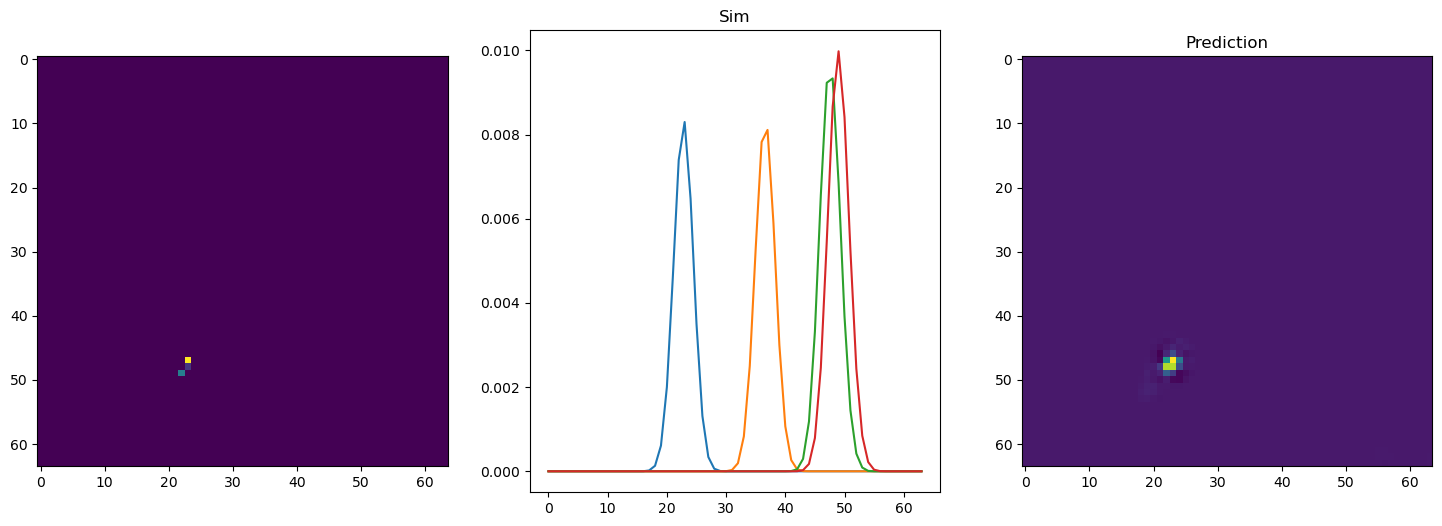

Key_id =  1000


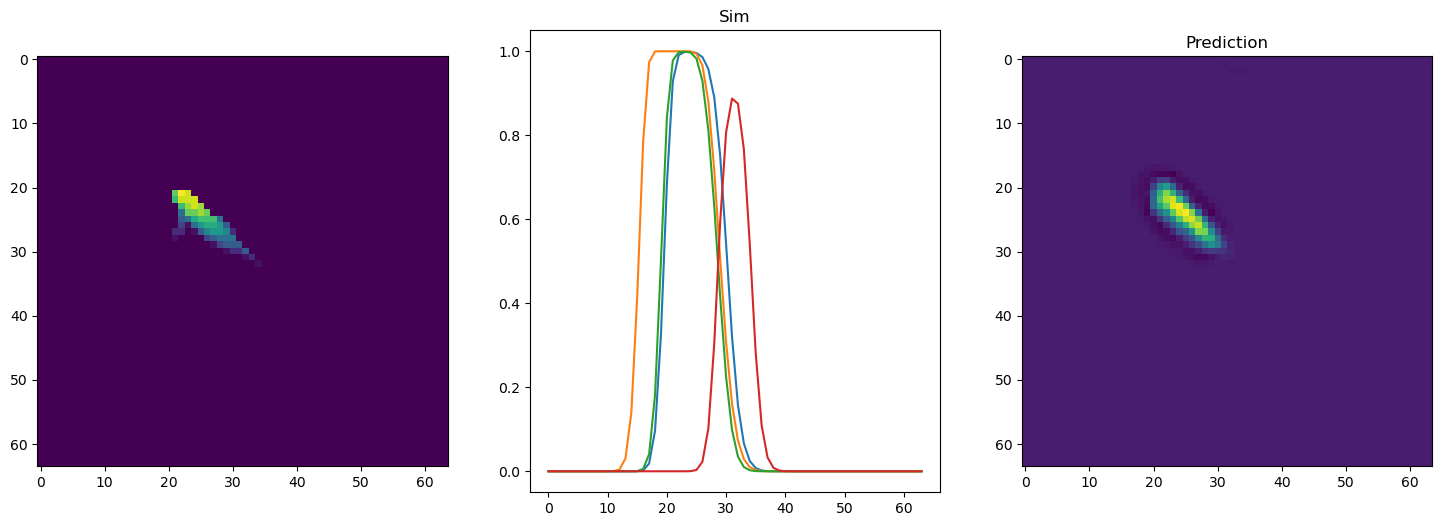

Key_id =  1010


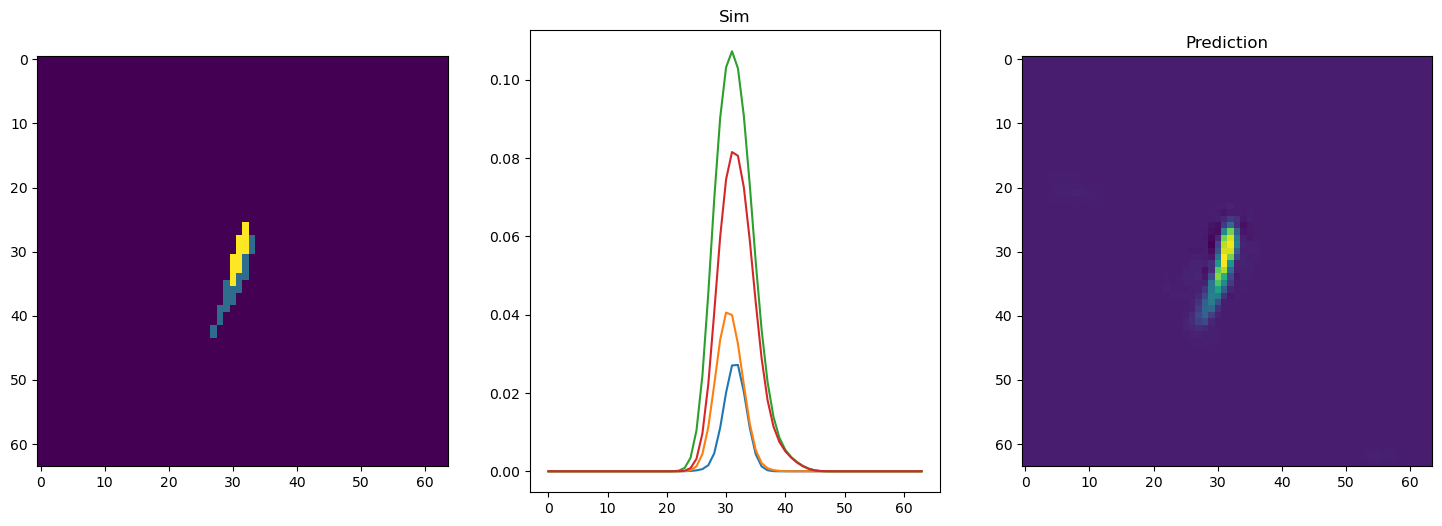

Key_id =  1020


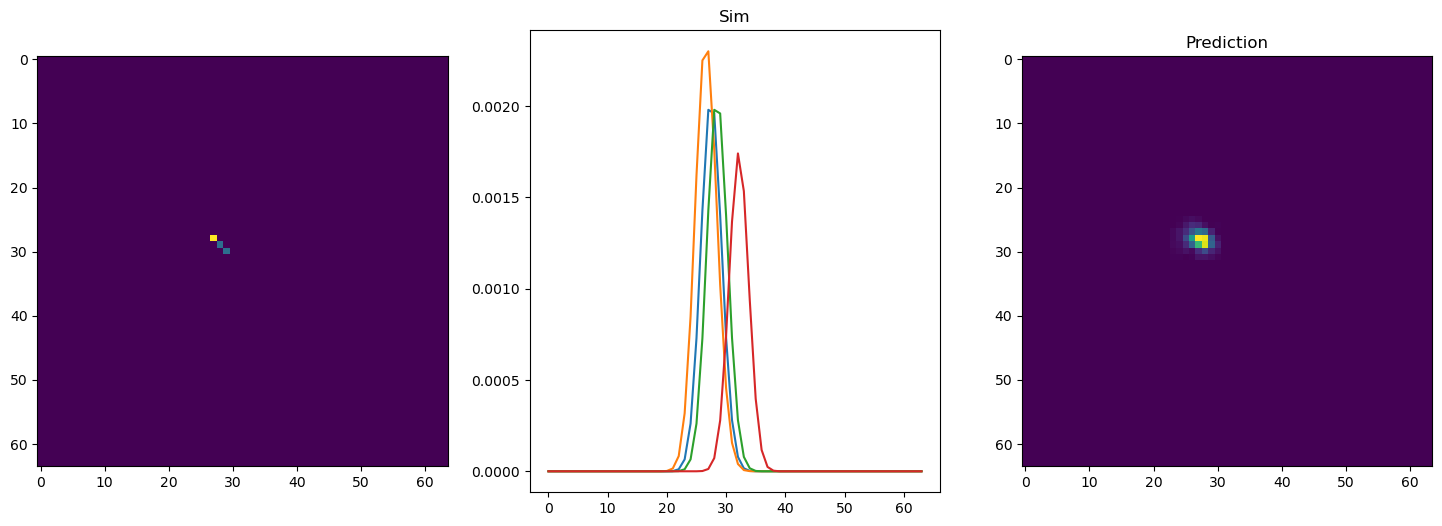

Key_id =  1030


IndexError: list index out of range

In [32]:
for key_id in range(550, 1050, 10):
    print("Key_id = ", key_id)
    pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)


    for i in range(110, 115, 5):
        # clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(pressure[i])
        # plt.title(f"{i}")
        # plt.colorbar()
        
        plt.subplot(1, 3, 2)
        plt.plot(signal[i].T)
        plt.title("Sim")
        
        # plt.subplot(2, 3, 3)
        # new_signal = sim.fiber_real_sim(pressure[i])
        # plt.plot(new_signal[0].T)
        # plt.title("Current sim")
        
        plt.subplot(1, 3, 3)
        map = predict(model, signal[i:i+1], device)
        plt.imshow(map[0])
        plt.title("Prediction")
        
        # plt.subplot(2, 3, 6)
        # map = predict(model, new_signal, device)
        # plt.imshow(map[0])
        # plt.title("new sim prediction")
        
    plt.show()
    # time.sleep(0.5)

In [46]:
for key_id in [41, 50, 57, 68, 76, 80, 90, 91, 92]:
    print("Key_id = ", key_id)
    pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)


    for i in range(110, 115, 5):
        # clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(pressure[i])
        plt.title("Original")
        # plt.colorbar()
        
        plt.subplot(1, 3, 2)
        plt.plot(signal[i].T)
        plt.title("Sim")
        
        # plt.subplot(2, 3, 3)
        # new_signal = sim.fiber_real_sim(pressure[i])
        # plt.plot(new_signal[0].T)
        # plt.title("Current sim")
        
        plt.subplot(1, 3, 3)
        map = predict(model, signal[i:i+1], device)
        plt.imshow(map[0])
        plt.title("Prediction")
        
        # plt.subplot(2, 3, 6)
        # map = predict(model, new_signal, device)
        # plt.imshow(map[0])
        # plt.title("new sim prediction")
    # plt.savefig(f"example_id={key_id}.jpg", dpi=300)
    # plt.show()
    plt.close()
    # time.sleep(0.5)

Key_id =  41
Key_id =  50
Key_id =  57
Key_id =  68
Key_id =  76
Key_id =  80
Key_id =  90
Key_id =  91
Key_id =  92


In [45]:
for key_id in [112, 134, 143, 145, 147, 148, 350, 390, 410, 830]:
    print("Key_id = ", key_id)
    pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)


    for i in range(110, 115, 5):
        # clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(pressure[i])
        plt.title("Original")
        # plt.colorbar()
        
        plt.subplot(1, 3, 2)
        plt.plot(signal[i].T)
        plt.title("Sim")
        
        # plt.subplot(2, 3, 3)
        # new_signal = sim.fiber_real_sim(pressure[i])
        # plt.plot(new_signal[0].T)
        # plt.title("Current sim")
        
        plt.subplot(1, 3, 3)
        map = predict(model, signal[i:i+1], device)
        plt.imshow(map[0])
        plt.title("Prediction")
        
        # plt.subplot(2, 3, 6)
        # map = predict(model, new_signal, device)
        # plt.imshow(map[0])
        # plt.title("new sim prediction")
    # plt.savefig(f"example_id={key_id}.jpg", dpi=300)
    # plt.show()
    plt.close()
    # time.sleep(0.5)

Key_id =  112
Key_id =  134
Key_id =  143
Key_id =  145
Key_id =  147
Key_id =  148
Key_id =  350
Key_id =  390
Key_id =  410
Key_id =  830


Key_id =  135


/tmp/ipykernel_149280/1331297641.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


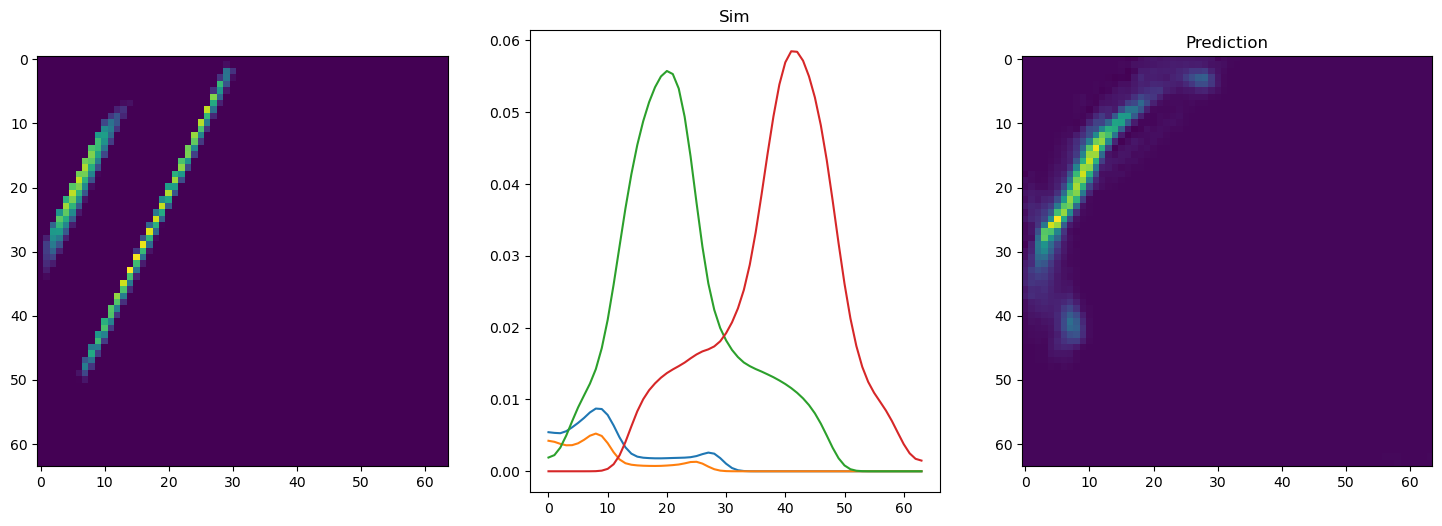

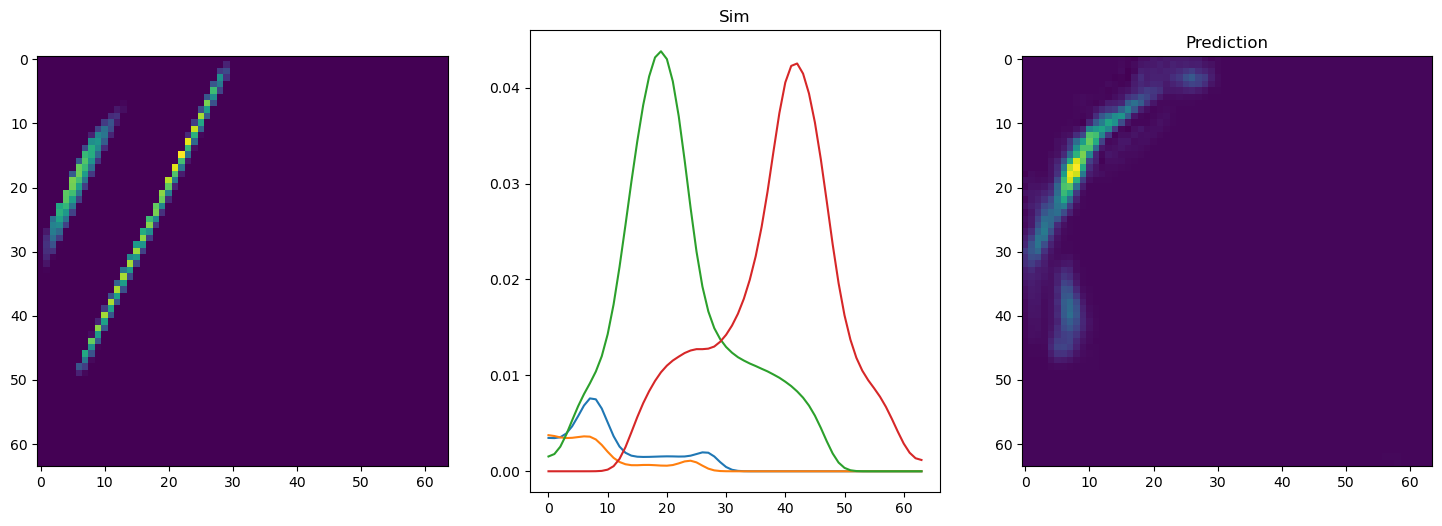

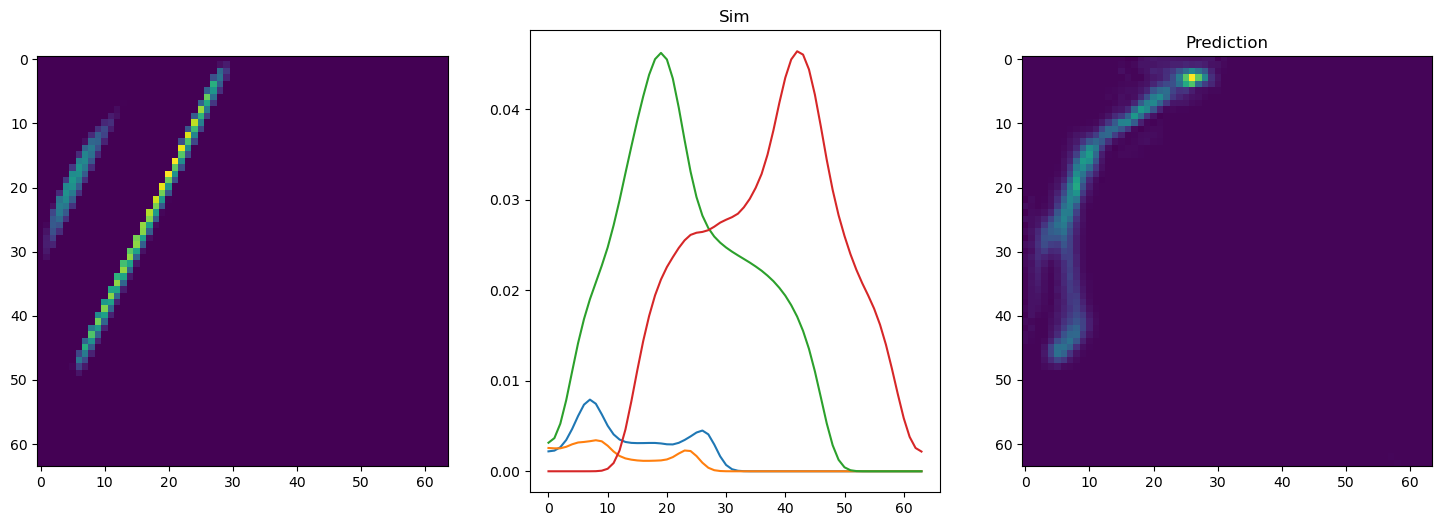

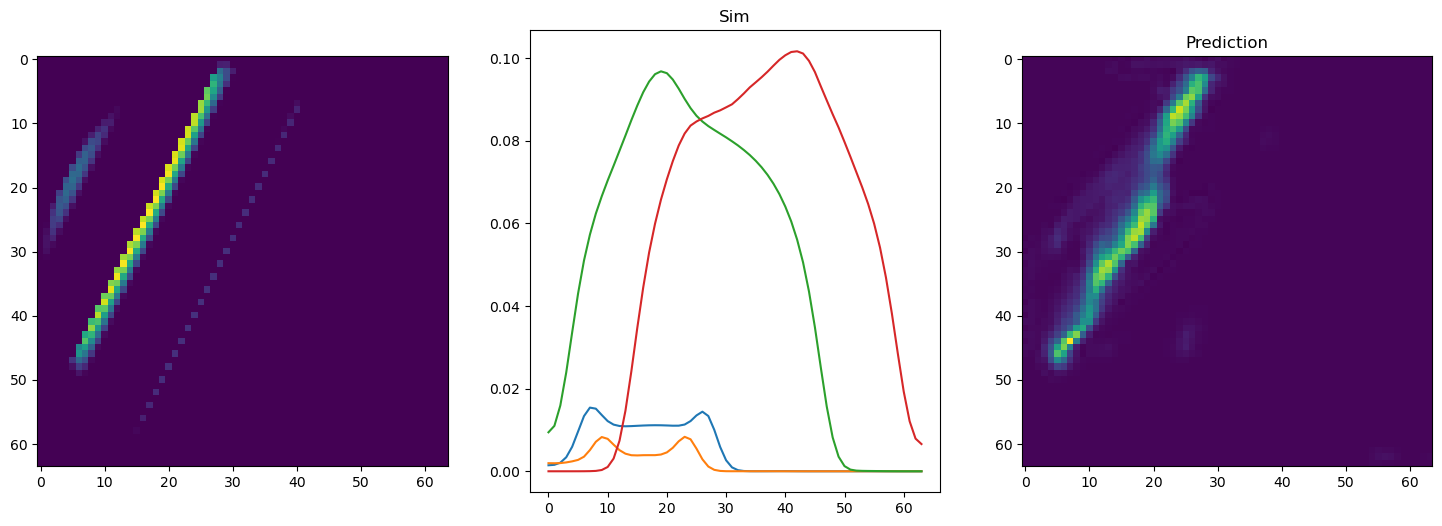

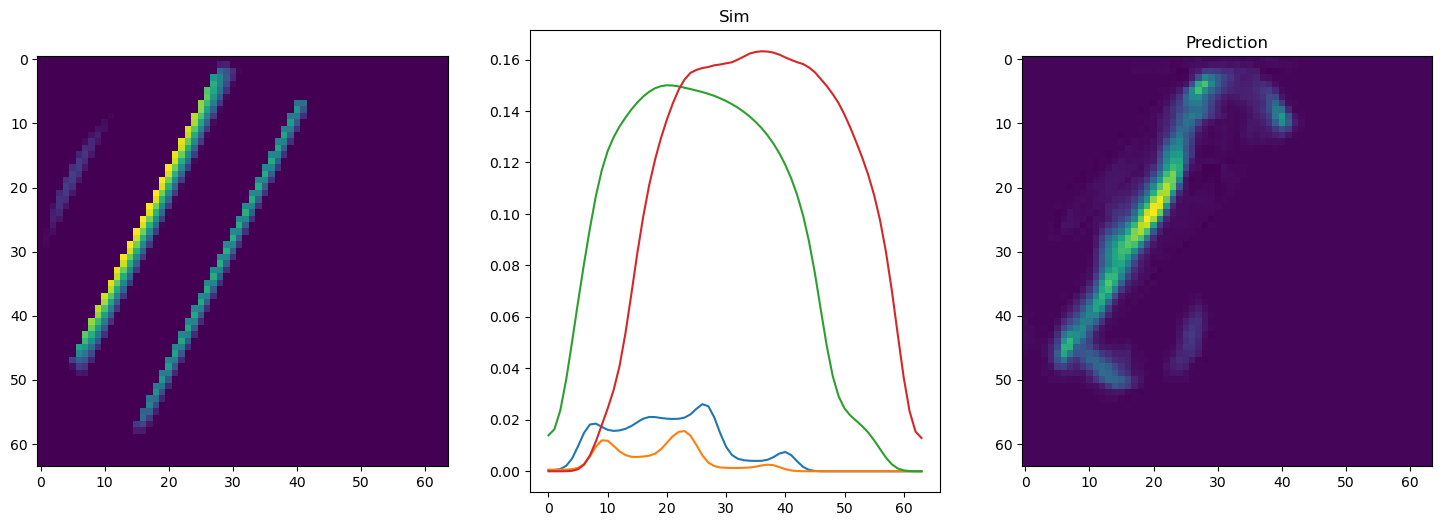

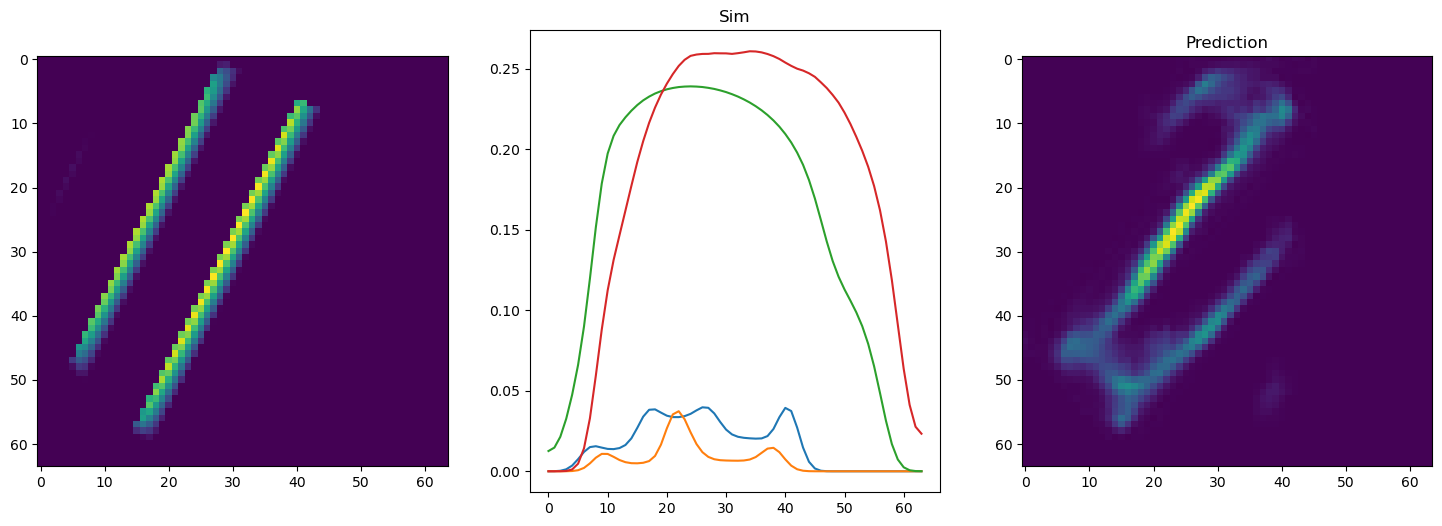

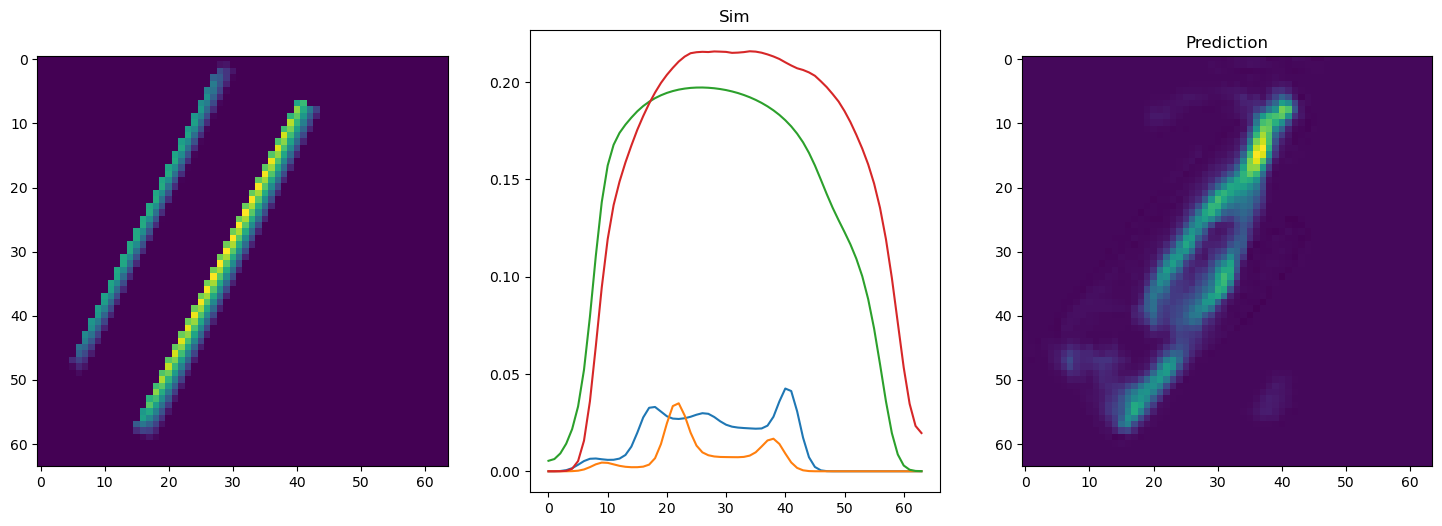

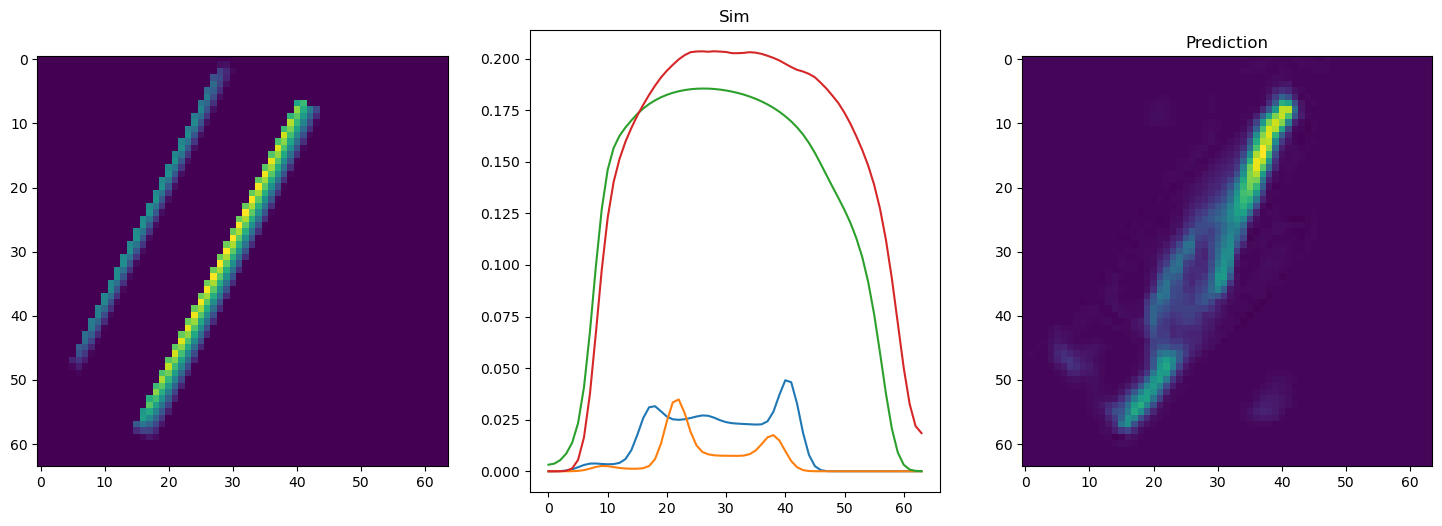

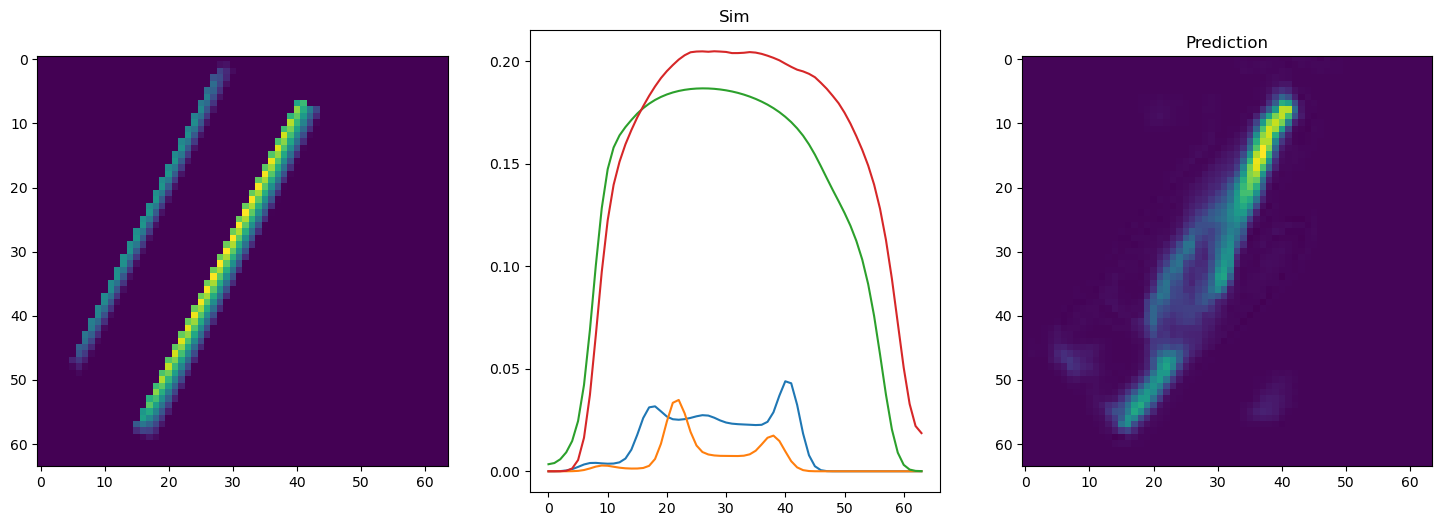

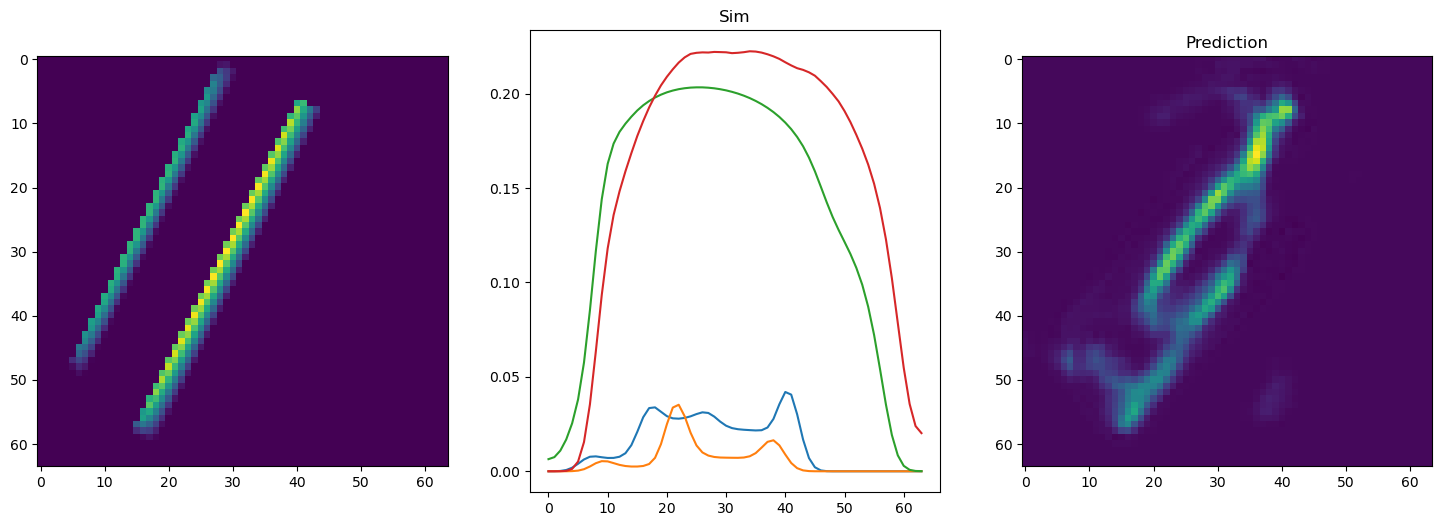

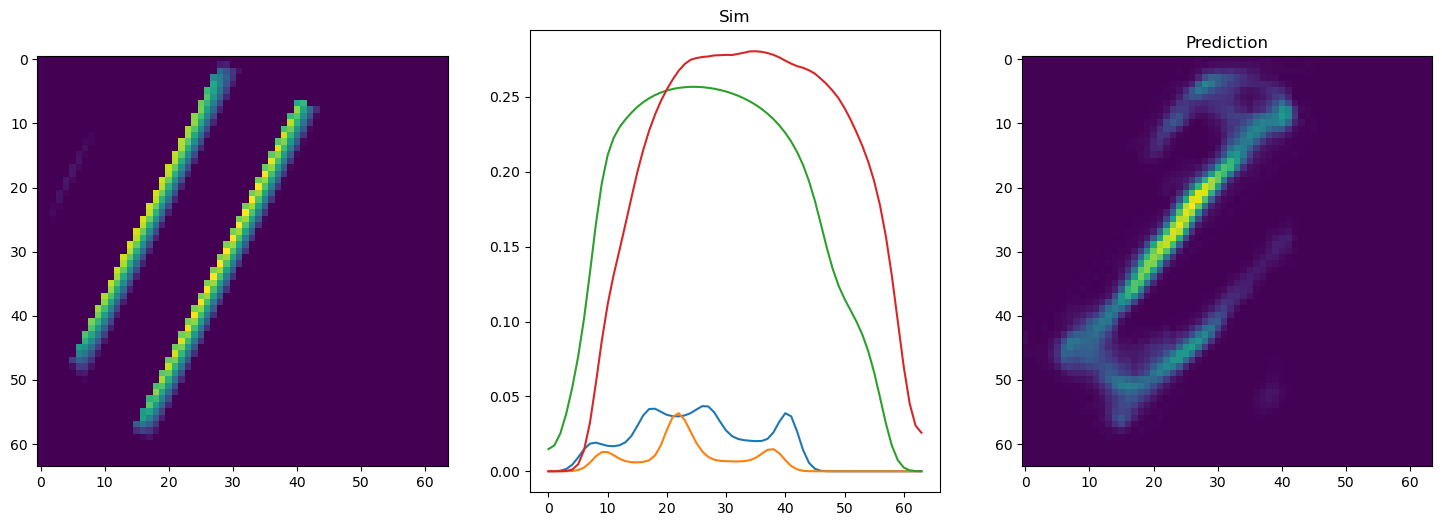

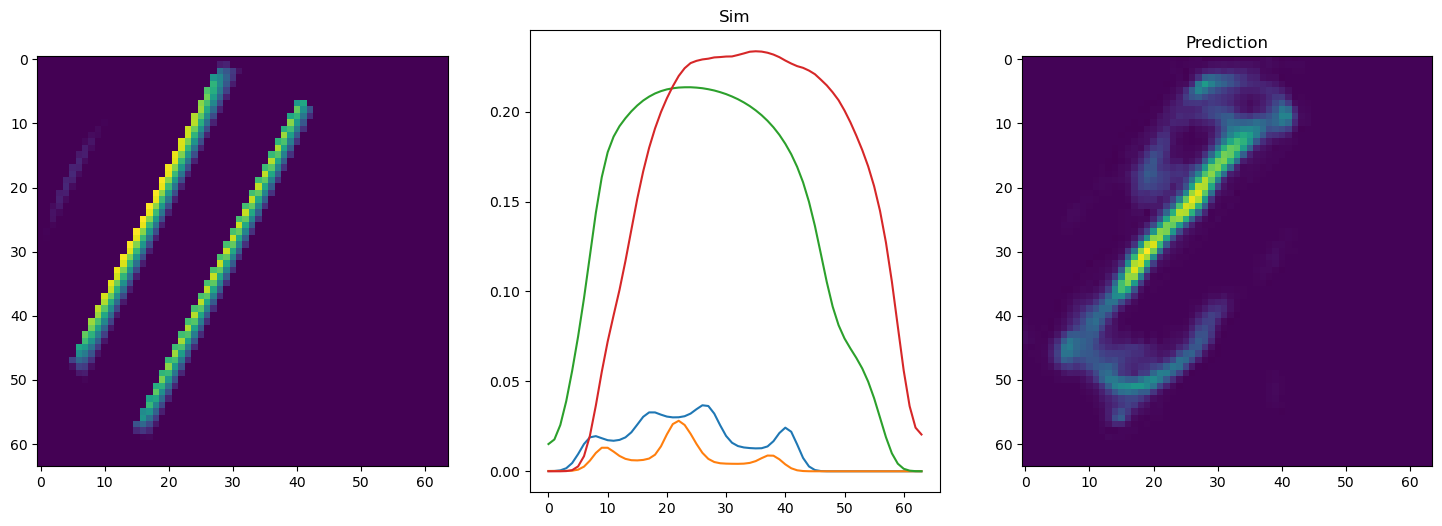

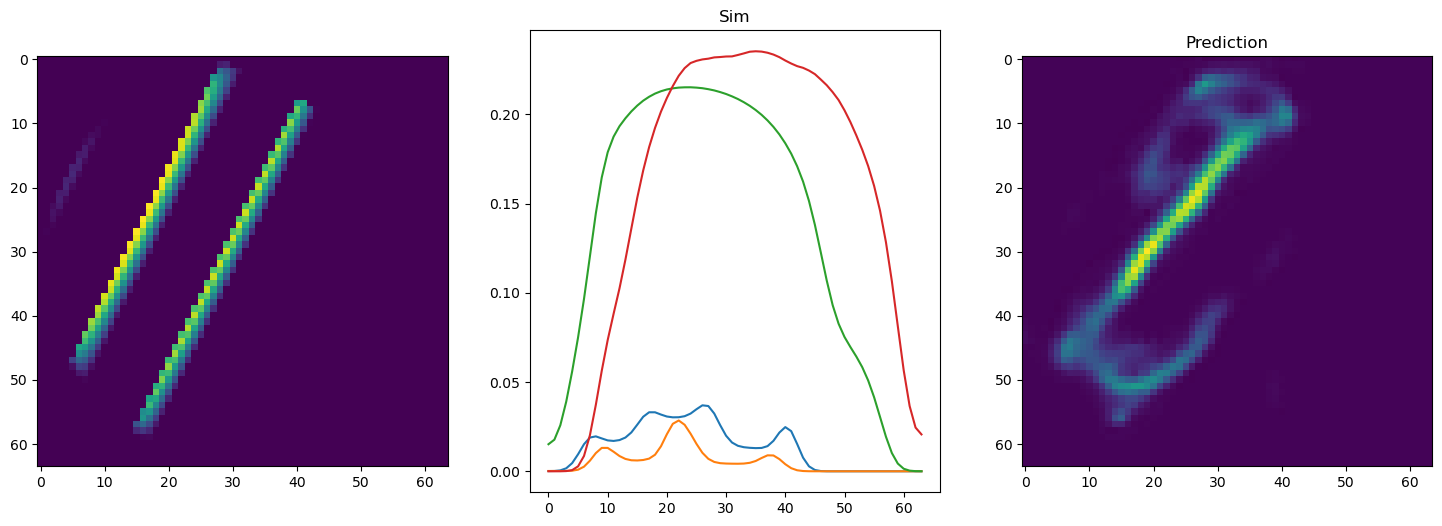

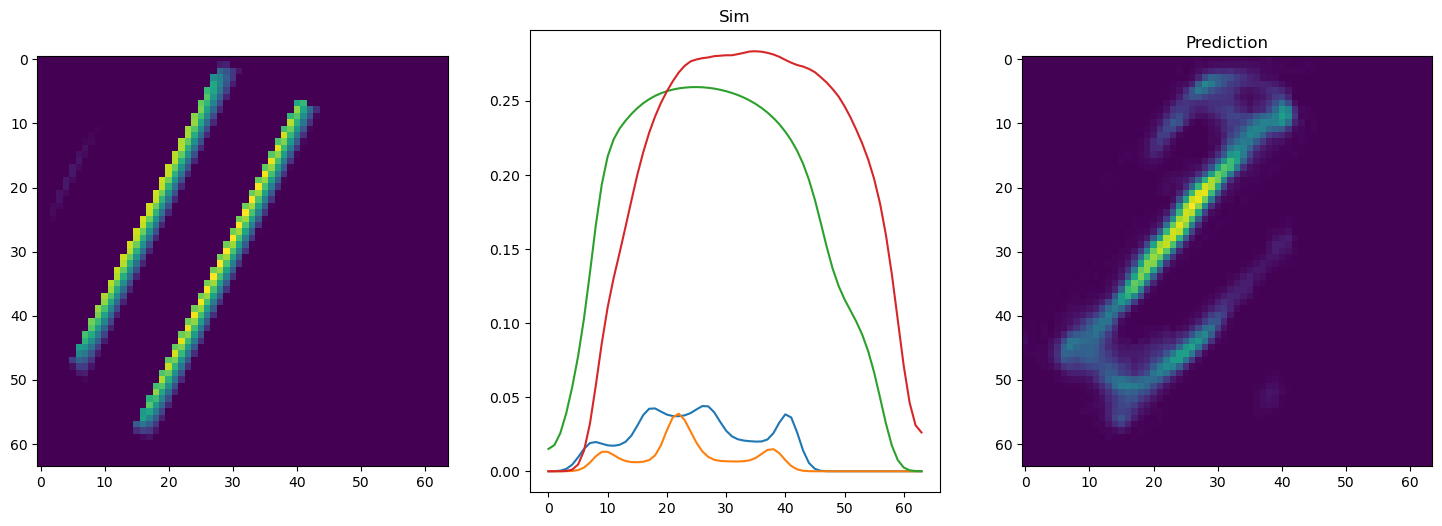

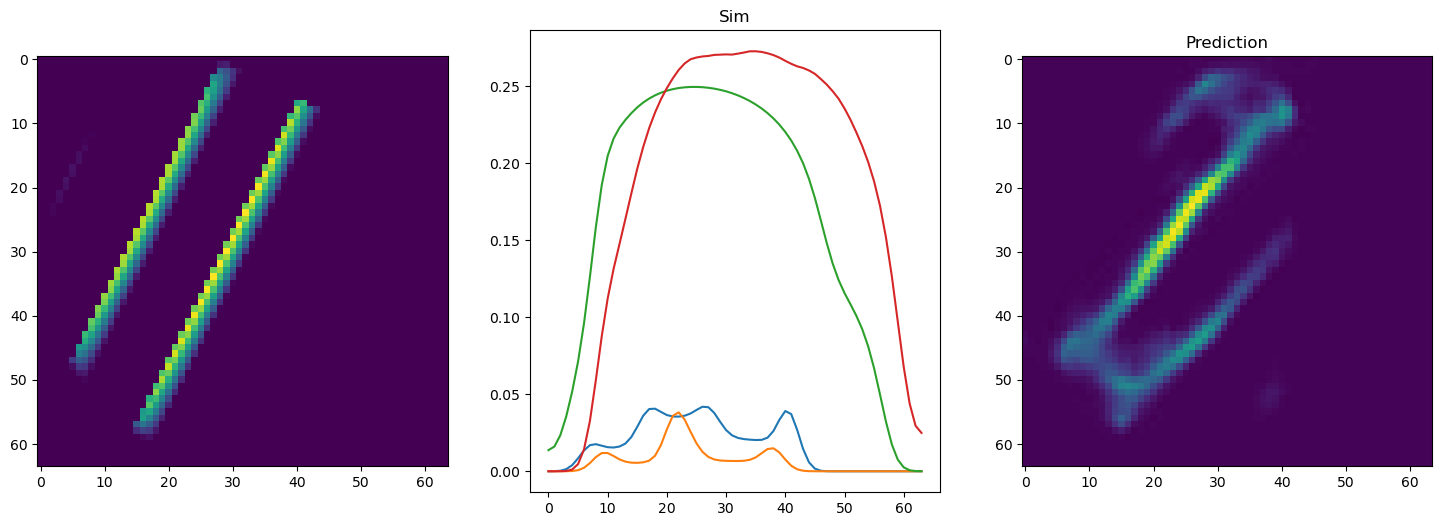

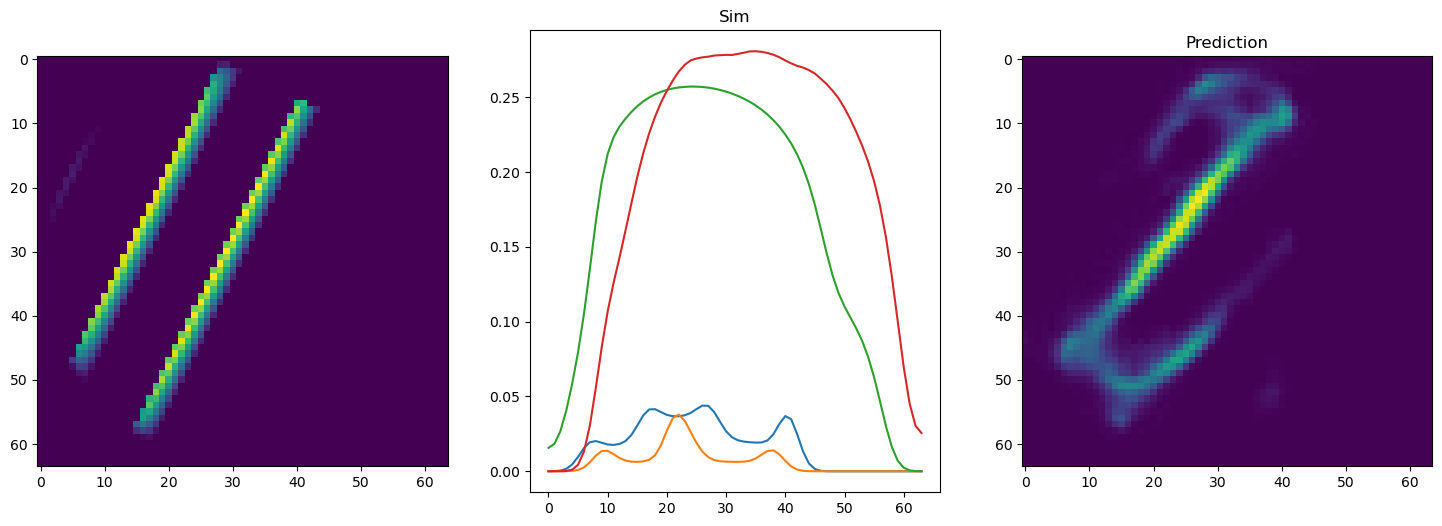

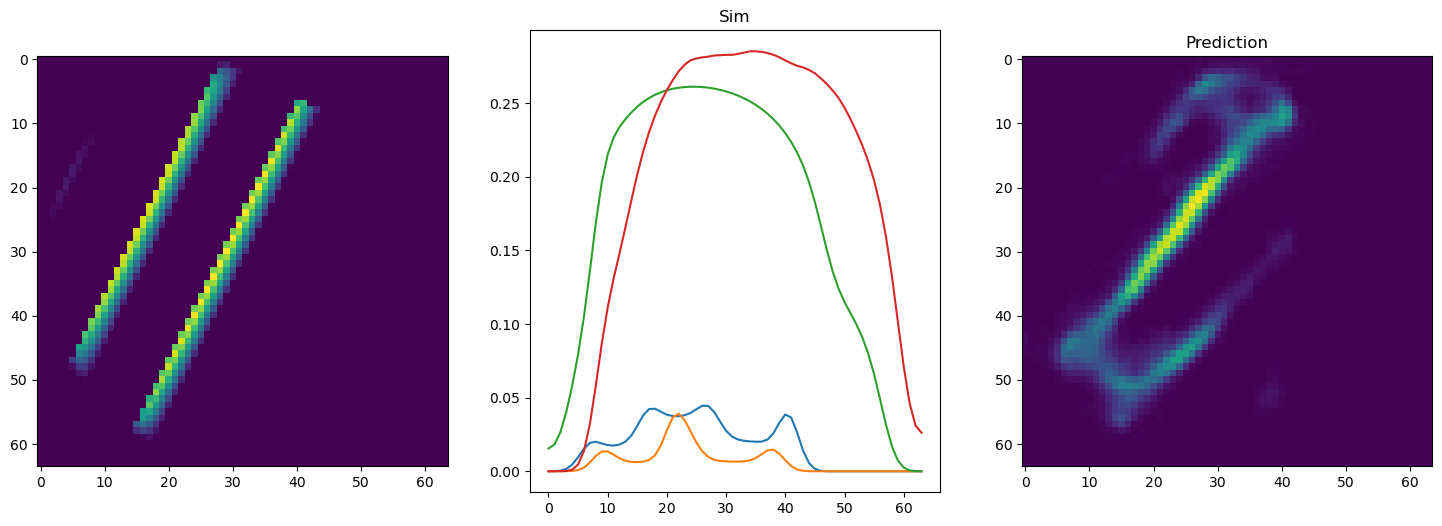

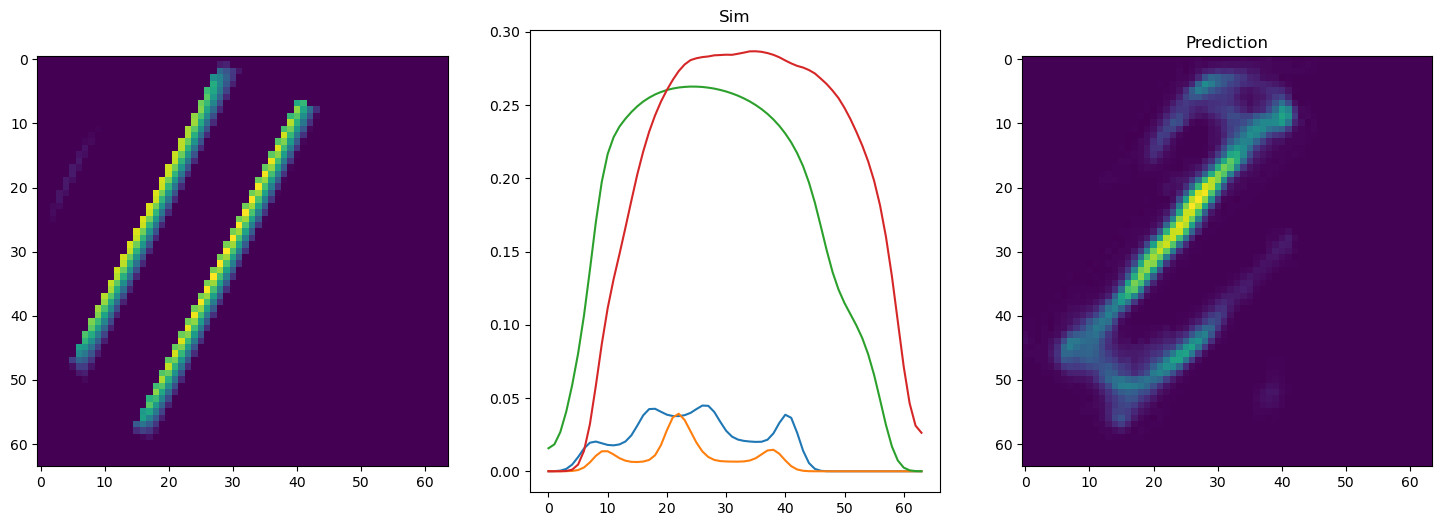

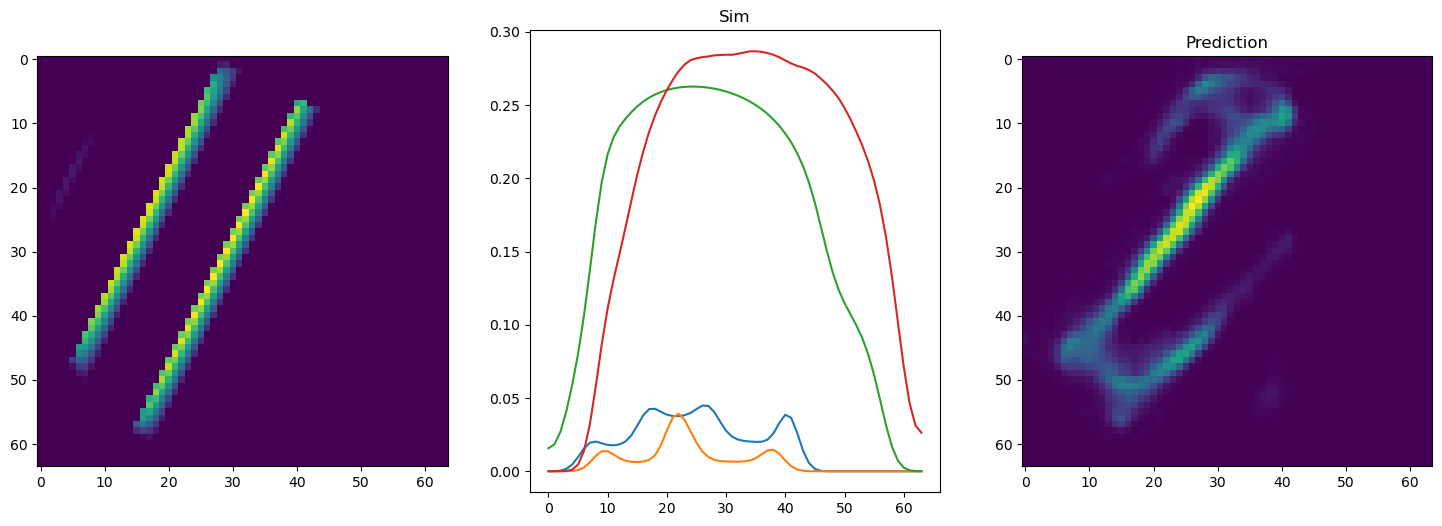

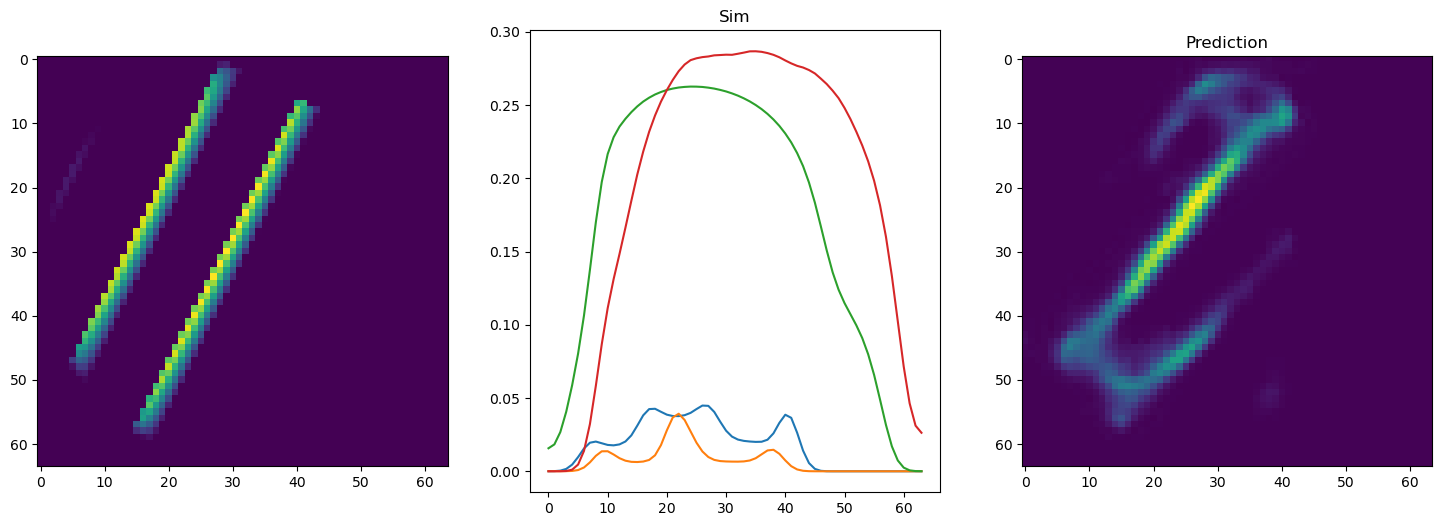

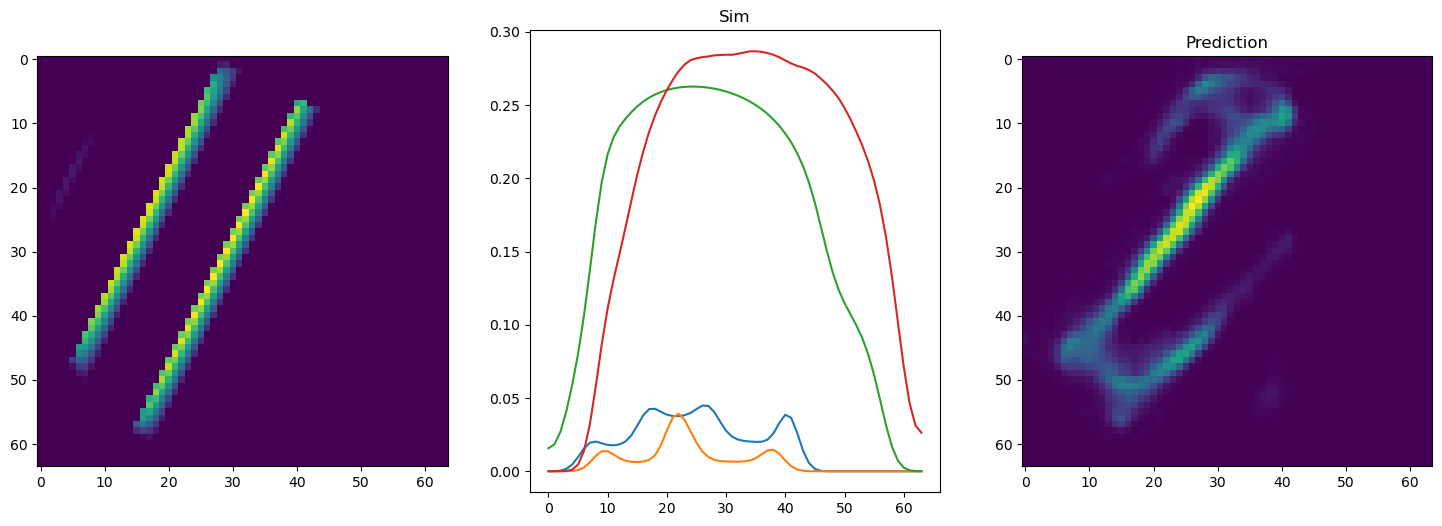

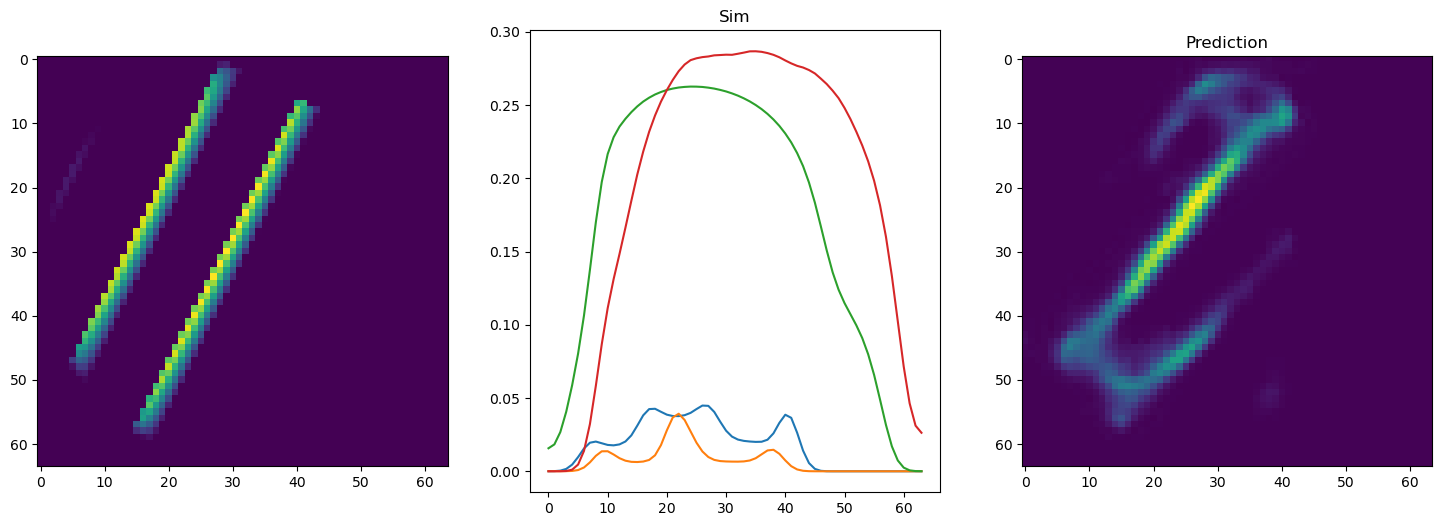

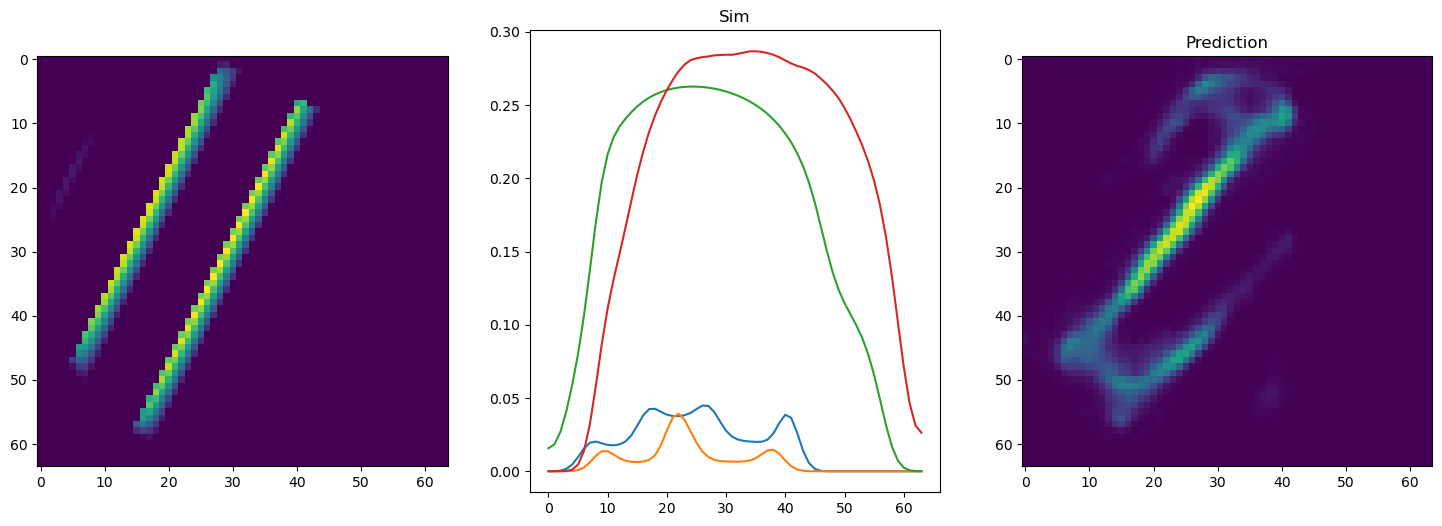

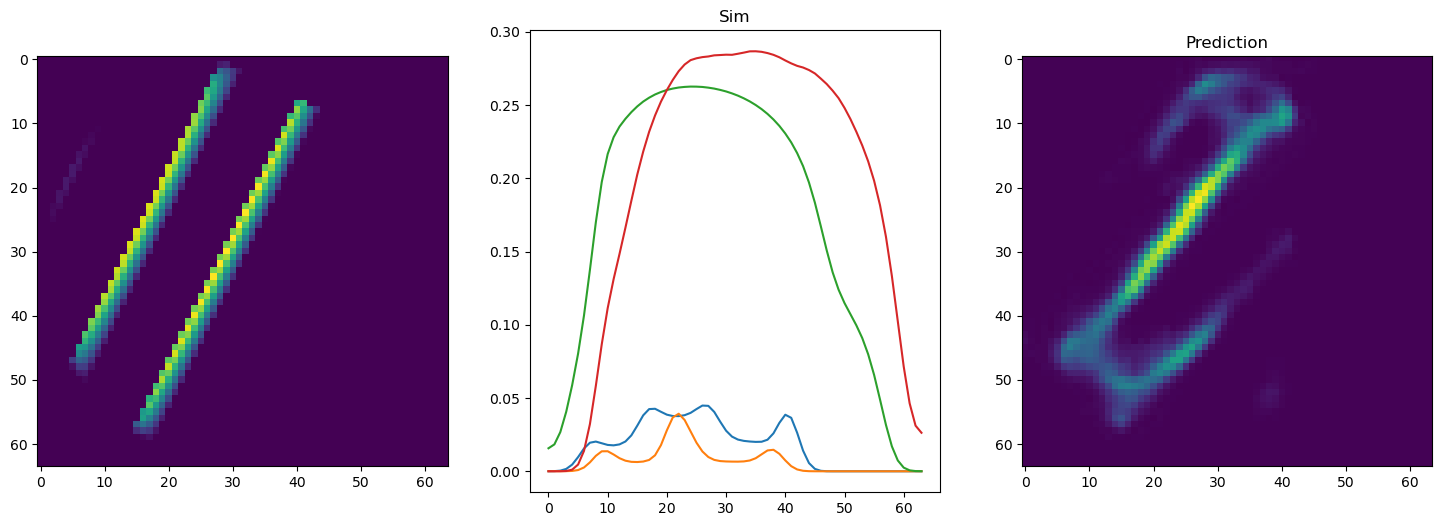

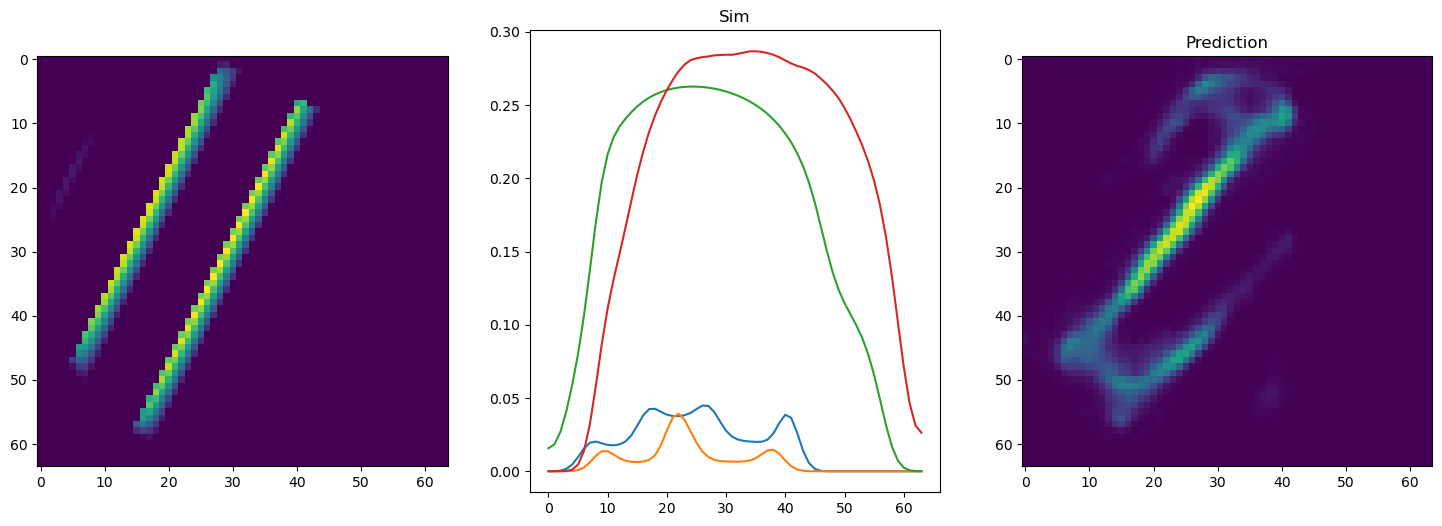

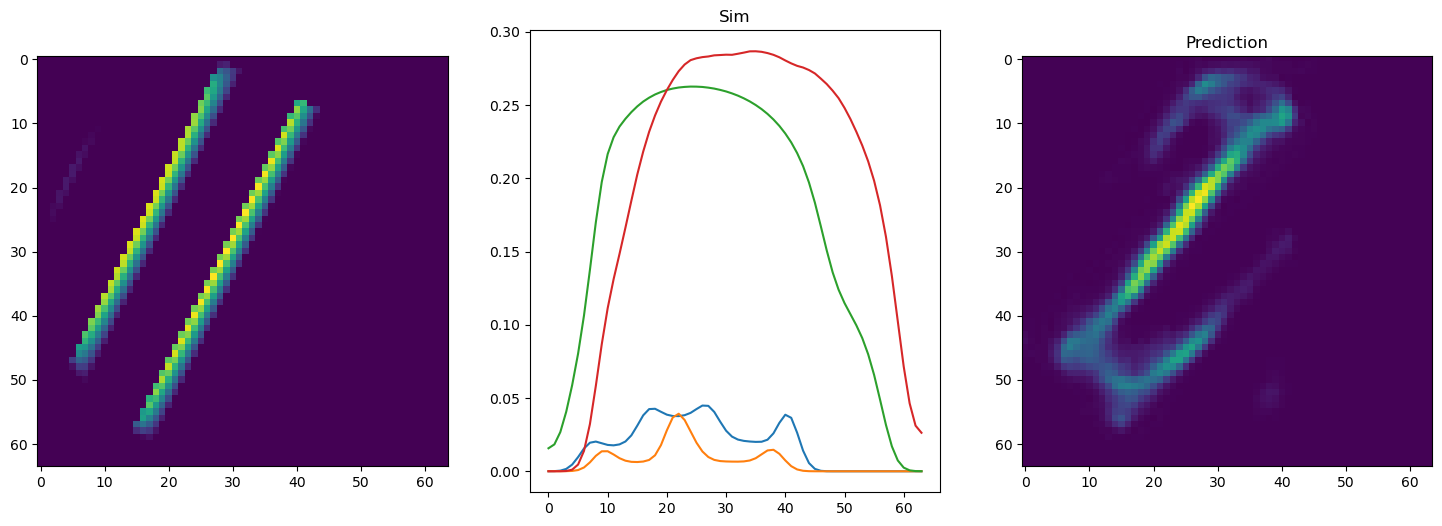

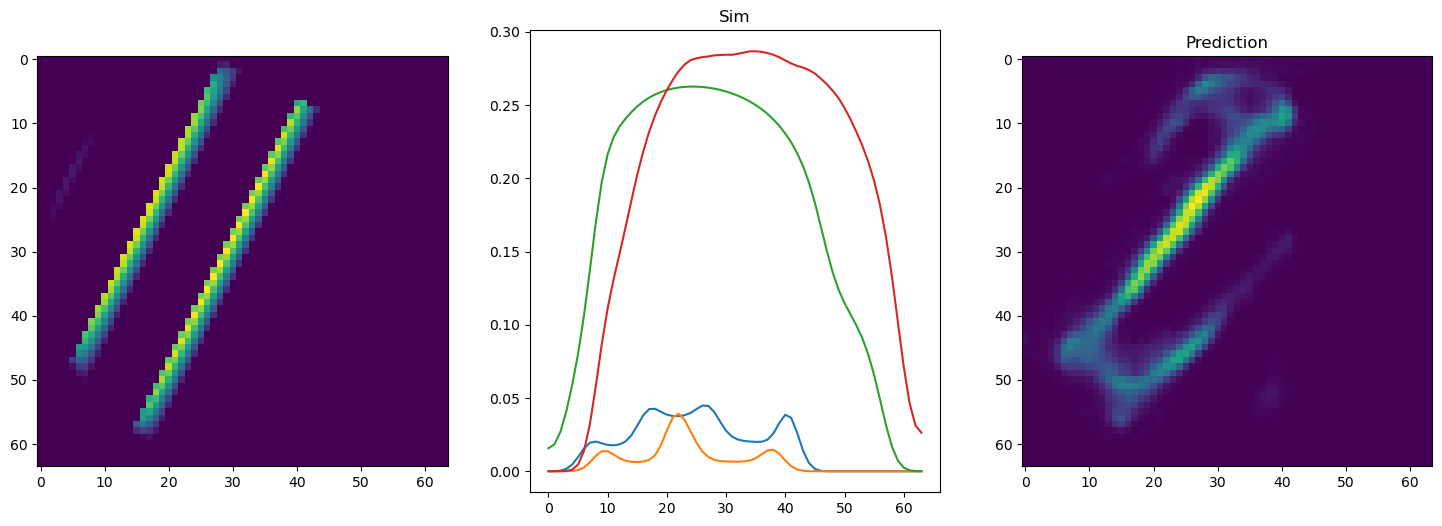

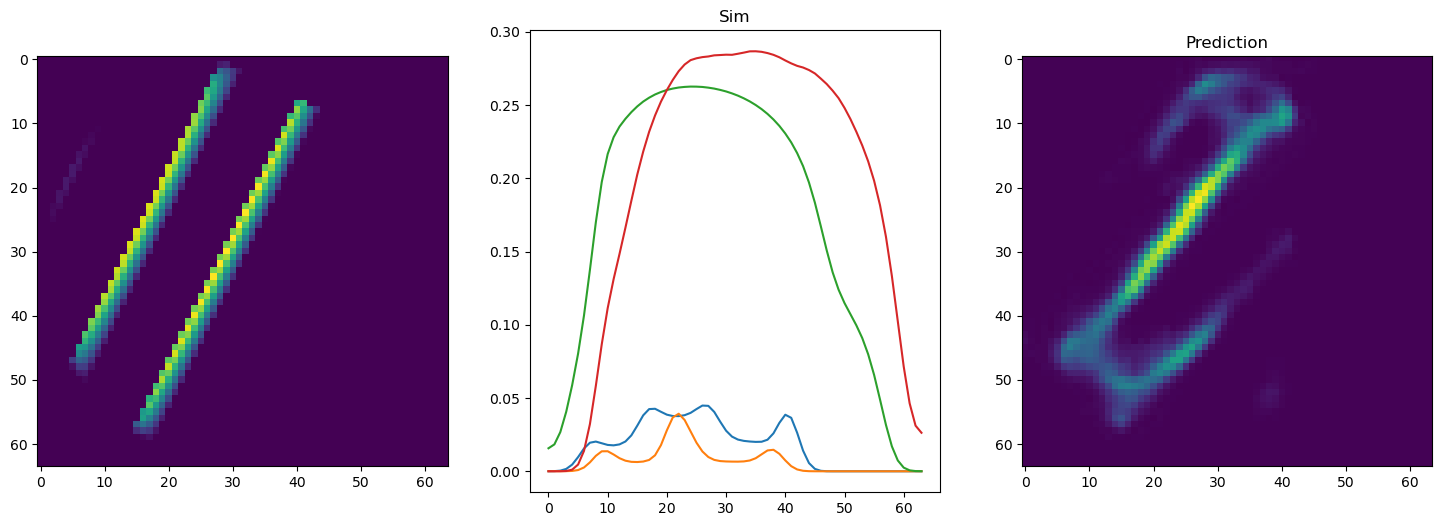

In [36]:
for key_id in [135]:
    print("Key_id = ", key_id)
    pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)


    for i in range(110, 250, 5):
        # clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(pressure[i])
        # plt.title(f"{i}")
        # plt.colorbar()
        
        plt.subplot(1, 3, 2)
        plt.plot(signal[i].T)
        plt.title("Sim")
        
        # plt.subplot(2, 3, 3)
        # new_signal = sim.fiber_real_sim(pressure[i])
        # plt.plot(new_signal[0].T)
        # plt.title("Current sim")
        
        plt.subplot(1, 3, 3)
        map = predict(model, signal[i:i+1], device)
        plt.imshow(map[0])
        plt.title("Prediction")
        
        # plt.subplot(2, 3, 6)
        # map = predict(model, new_signal, device)
        # plt.imshow(map[0])
        # plt.title("new sim prediction")
        
    plt.show()
    plt.close()
    # time.sleep(0.5)

In [47]:
for key_id in [135]:
    print("Key_id = ", key_id)
    pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)


    for i in range(185, 186, 5):
        # clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(pressure[i])
        plt.title("Original")
        # plt.colorbar()
        
        plt.subplot(1, 3, 2)
        plt.plot(signal[i].T)
        plt.title("Sim")
        
        # plt.subplot(2, 3, 3)
        # new_signal = sim.fiber_real_sim(pressure[i])
        # plt.plot(new_signal[0].T)
        # plt.title("Current sim")
        
        plt.subplot(1, 3, 3)
        map = predict(model, signal[i:i+1], device)
        plt.imshow(map[0])
        plt.title("Prediction")
        
        # plt.subplot(2, 3, 6)
        # map = predict(model, new_signal, device)
        # plt.imshow(map[0])
        # plt.title("new sim prediction")
        # plt.savefig(f"example_id={key_id}:{i}.jpg", dpi=300)
    # plt.show()
    plt.close()
    # time.sleep(0.5)

Key_id =  135


Key_id =  830


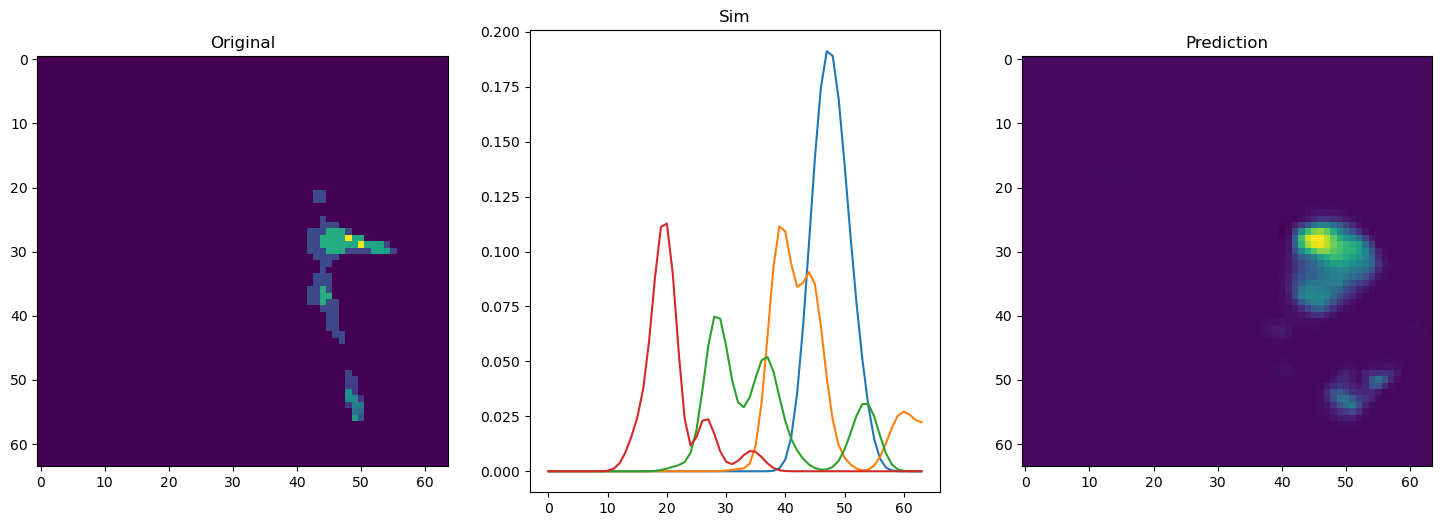

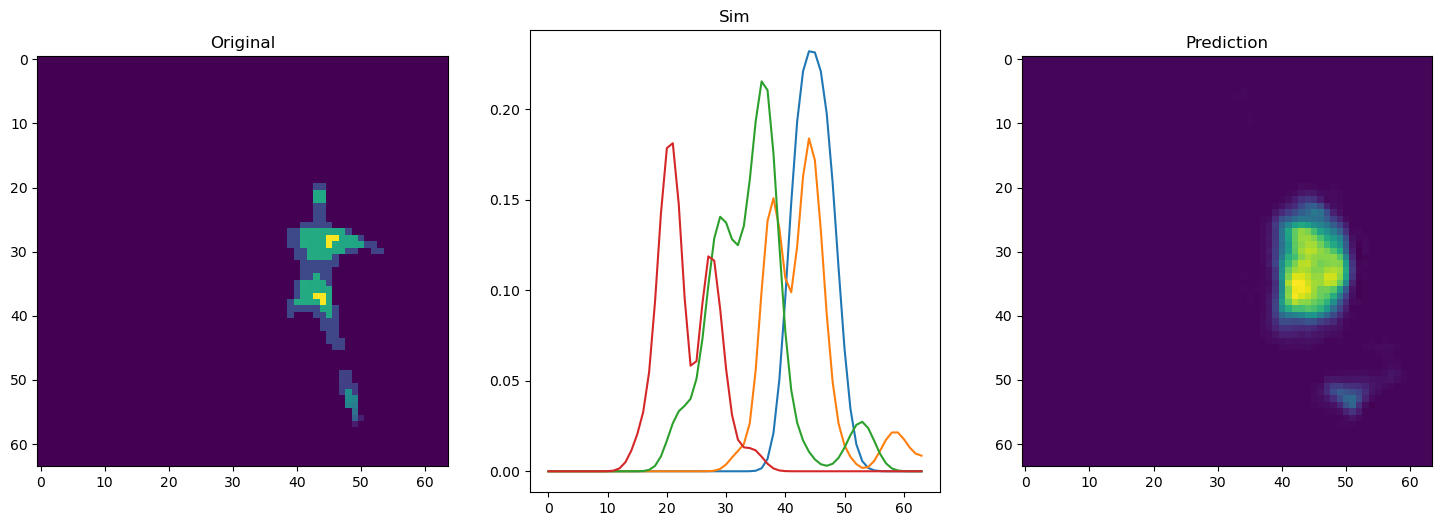

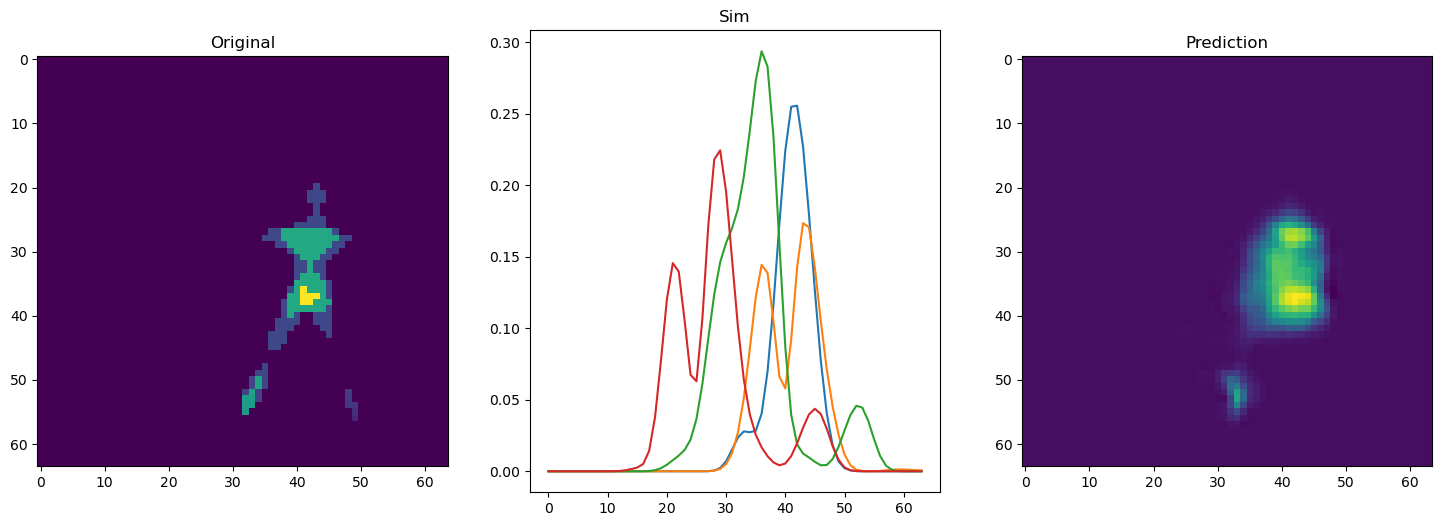

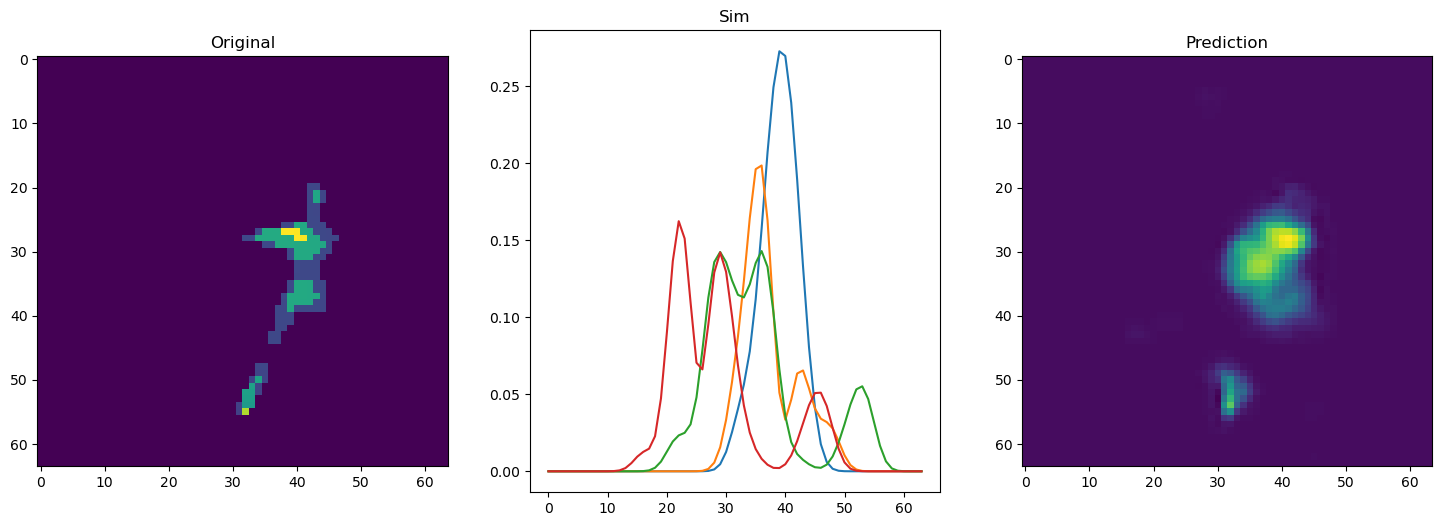

In [44]:
for key_id in [830]:
    print("Key_id = ", key_id)
    pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)


    for i in range(190, 215, 5):
        # clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(pressure[i])
        plt.title("Original")
        # plt.colorbar()
        
        plt.subplot(1, 3, 2)
        plt.plot(signal[i].T)
        plt.title("Sim")
        
        # plt.subplot(2, 3, 3)
        # new_signal = sim.fiber_real_sim(pressure[i])
        # plt.plot(new_signal[0].T)
        # plt.title("Current sim")
        
        plt.subplot(1, 3, 3)
        map = predict(model, signal[i:i+1], device)
        plt.imshow(map[0])
        plt.title("Prediction")
        
        # plt.subplot(2, 3, 6)
        # map = predict(model, new_signal, device)
        # plt.imshow(map[0])
        # plt.title("new sim prediction")
        # plt.savefig(f"example_id={key_id}:{i}.jpg", dpi=300)
    # plt.show()
    plt.close()
    # time.sleep(0.5)